# Working out new analyses for the sfBB_* series

Last access (y.m.d): 21.02.25  
Last update (y.m.d): 21.02.25   
Created ---- (y.m.d): 20.09.22  

Starting in the lead-up to m684, we designed a new stimulus set based on the Bauman & Bonds (1991) paper. Specifically, we wanted:
- To directly access whether the suppression we observed in the original sfMix* experiments are a gain control mechanism
- To measure the spatial frequency tuning of this suppression


### Table of contents

- Datalist, basics  
- Amplitude/phase correction  
- Transient correction (started 12.03.20)
- Var::Mean ratio  
- varBase/SF/CON plotting
- Superposition plots


In [928]:
import numpy as np
import helper_fcns as hf
import os

import helper_fcns_sfBB as hf_sf
import scipy.optimize as opt
import autoreload

import itertools
from collections import defaultdict
import pandas as pd

from scipy.stats.mstats import gmean
from scipy.stats import nbinom

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
import matplotlib.backends.backend_pdf as pltSave
%matplotlib inline

import warnings

warnings.filterwarnings('once')

In [911]:
for i in range(2):
    # must run twice for changes to take effect?

    from matplotlib import rcParams, cm
    rcParams['font.family'] = 'sans-serif'
    # rcParams['font.sans-serif'] = ['Helvetica']
    rcParams['font.style'] = 'oblique'
    rcParams['font.size'] = 30;
    rcParams['pdf.fonttype'] = 3 # should be 42, but there are kerning issues
    rcParams['ps.fonttype'] = 3 # should be 42, but there are kerning issues
    rcParams['lines.linewidth'] = 3;
    rcParams['lines.markeredgewidth'] = 0; # remove edge??                                                                                                                               
    rcParams['axes.linewidth'] = 3;
    rcParams['lines.markersize'] = 12; # 8 is the default                                                                                                                                
    rcParams['font.style'] = 'oblique';

    rcParams['xtick.major.size'] = 25
    rcParams['xtick.minor.size'] = 12
    rcParams['ytick.major.size'] = 25
    rcParams['ytick.minor.size'] = 12; # i.e. don't have minor ticks on y...                                                                                                              

    rcParams['xtick.major.width'] = 2
    rcParams['xtick.minor.width'] = 2
    rcParams['ytick.major.width'] = 2
    rcParams['ytick.minor.width'] = 2

In [4]:
expDir = 'V1_BB/';
path = '%sstructures/' % expDir;


## Datalist, basics

The original datalist was created from within ExpoAnalysisTools/python/. Now, we want to add to this datalist the basic programs, and build analysis of these basics. The core basic analysis is done in helper_fcns/get_basic_tunings()  

First, get the basic programs associated with each file (build_basics_list.py), then run the get_basic_tunings function for analysis

In [532]:
dl_name = 'dataList_210222.npy'

expDir = 'V1_BB/';
path = '%sstructures/' % expDir;
dataList = hf.np_smart_load(path + dl_name)

cellNames = dataList['unitName'];

import build_basics_list as bbl
basic_list, _, _, basic_order = bbl.build_basic_lists(cellNames, expExt='', loc=expDir, folderByExpt=False, reduceNums=True)

In [533]:
# # UPDATE the basic prog order (overall, names (for each cell separately, as a list)
dataList['basicProgOrder'] = basic_order;
dataList['basicProgName'] = [];
for lst in basic_list:
    dataList['basicProgName'].append(lst);
    

In [534]:
# Now save the updated datalist
np.save(path + dl_name, dataList)

In [535]:
autoreload.reload(hf)

<module 'helper_fcns' from '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py'>

In [ ]:
# now do the analysis...
dataList = hf.np_smart_load(path + dl_name)

basics_dc = []; basics_f1 = [];
for progList in dataList['basicProgName']:
    basic_dc = hf.get_basic_tunings(progList, dataList['basicProgOrder'], forceSimple=0)
    basic_f1 = hf.get_basic_tunings(progList, dataList['basicProgOrder'], forceSimple=1)
    
    basics_dc.append(basic_dc);
    basics_f1.append(basic_f1);

ExpoAnalysisTools/python/get_events.py:79: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if valInds == []:
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:4356: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1502: RuntimeWarning: invalid value encountered in true_divide
  #   only include prefSf values derived from a descrFit whose variance explained is gt the thresh
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1378: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/s

#### Distribution of tuning parameters, as inferred from basic tuning parameters

In [ ]:
# First, organize the parameters
nCells = len(basics_dc);

f1f0_ratSF = np.array([basics_dc[x]['sf']['sf_exp']['f1f0_rat'] for x in np.arange(nCells)]);
f1f0_ratRVC = np.array([basics_dc[x]['rvc']['rvc_exp']['f1f0_rat'] for x in np.arange(nCells)]);

### SF
sfPref_dc = np.array([basics_dc[x]['sf']['sfPref'] for x in np.arange(nCells)]);
sfPref_f1 = np.array([basics_f1[x]['sf']['sfPref'] for x in np.arange(nCells)]);
### RVC
c50_dc = np.array([basics_dc[x]['rvc']['c50'] for x in np.arange(nCells)]);
c50eval_dc = np.array([basics_dc[x]['rvc']['c50_eval'][0] for x in np.arange(nCells)]);
c50_f1 = np.array([basics_f1[x]['rvc']['c50'] for x in np.arange(nCells)]);
c50eval_f1 = np.array([basics_f1[x]['rvc']['c50_eval'][0] for x in np.arange(nCells)]);
### ORI
oriPref_dc = np.array([basics_dc[x]['ori']['pref'] for x in np.arange(nCells)]);
oriPref_f1 = np.array([basics_f1[x]['ori']['pref'] for x in np.arange(nCells)]);
oriCV_dc = np.array([basics_dc[x]['ori']['cv'] for x in np.arange(nCells)]);
oriCV_f1 = np.array([basics_f1[x]['ori']['cv'] for x in np.arange(nCells)]);
oriBW_dc = np.array([basics_dc[x]['ori']['bw'] for x in np.arange(nCells)]);
oriBW_f1 = np.array([basics_f1[x]['ori']['bw'] for x in np.arange(nCells)]);
### RFSIZE
# rfSize data/model
rfSize_data_dc = np.array([basics_dc[x]['rfsize']['gsf_data'] for x in np.arange(nCells)]);
rfSize_mod_dc = np.array([basics_dc[x]['rfsize']['gsf_model'] for x in np.arange(nCells)]);
rfSize_data_f1 = np.array([basics_f1[x]['rfsize']['gsf_data'] for x in np.arange(nCells)]);
rfSize_mod_f1 = np.array([basics_f1[x]['rfsize']['gsf_model'] for x in np.arange(nCells)]);
# rf supr. index data/model
rfSupr_data_dc = np.array([basics_dc[x]['rfsize']['suprInd_data'] for x in np.arange(nCells)]);
rfSupr_mod_dc = np.array([basics_dc[x]['rfsize']['suprInd_model'] for x in np.arange(nCells)]);
rfSupr_data_f1 = np.array([basics_f1[x]['rfsize']['suprInd_data'] for x in np.arange(nCells)]);
rfSupr_mod_f1 = np.array([basics_f1[x]['rfsize']['suprInd_model'] for x in np.arange(nCells)]);

##### F1:F0

In [ ]:
bins = np.linspace(-2, 2, 7); # in log space
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

f1f0s = [f1f0_ratSF, f1f0_ratRVC];
fitStr = ['SF', 'RVC']
ylim = [0, 0.5];

f1f0s_clipped = [np.clip(hf.nan_rm(np.log2(x)), clipLow, clipHigh) for x in f1f0s];
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)
# tickVals = np.linspace(bins[1]+0.5*stepSize, bins[-2]+0.5*stepSize, 10)

# calculate
nF1F0 = [len(x) for x in f1f0s_clipped]
medianF1F0 = [np.nanmedian(x) for x in f1f0s];
mnF1F0 = [np.nanmean(x) for x in f1f0s];
gmnF1F0 = [gmean(hf.nan_rm(x)) for x in f1f0s];

## now plot
nrow, ncol = 1, 2;
f, ax = plt.subplots(nrow, ncol, figsize=(ncol*12, nrow*14))

for i in range(2):

    plt.subplot(nrow,ncol,1+i)
    vals, _ = np.histogram(f1f0s_clipped[i], bins=bins)
    vals_norm = vals/np.sum(vals)
    plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
    sns.despine(offset=10)
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);
    plt.axvline(0, color='k', linestyle='--')

    plt.ylim(ylim);
    plt.xlabel('f1f0 ratio');
    plt.title('Simple|Complex [%s] (V1, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], nF1F0[i], medianF1F0[i], mnF1F0[i], gmnF1F0[i]));

# now save
saveName = "/f1f0_basics.pdf" % (cellNum)
full_save = os.path.dirname(str(save_loc + 'pop_distr/'));
if not os.path.exists(full_save):
    os.makedirs(full_save);
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f)
pdfSv.close()


##### Pref SF

In [ ]:
bins = np.linspace(-2.5, 3.5, 9); # in log space
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

psfs = [sfPref_dc, sfPref_f1];
fitStr = ['DC', 'F1']
ylim = [0, 0.35];

psfs_clipped = [np.clip(hf.nan_rm(np.log2(x)), clipLow, clipHigh) for x in psfs];
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)
# tickVals = np.linspace(bins[1]+0.5*stepSize, bins[-2]+0.5*stepSize, 10)

# calculate
nSF = [len(x) for x in psfs_clipped]
medianSF = [np.nanmedian(x) for x in psfs];
mnSF = [np.nanmean(x) for x in psfs];
gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

## now plot
nrow, ncol = 1, 2;
f, ax = plt.subplots(nrow, ncol, figsize=(ncol*12, nrow*12))

for i in range(2):

    plt.subplot(nrow,ncol,1+i)
    vals, _ = np.histogram(psfs_clipped[i], bins=bins)
    vals_norm = vals/np.sum(vals)
    plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
    sns.despine(offset=10)
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);

    plt.ylim(ylim);
    plt.xlabel('spatial frequency (c/deg)');
    plt.title('sf pref [%s] (V1, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], nSF[i], medianSF[i], mnSF[i], gmnSF[i]));

# now save
saveName = "/prefSf_basics.pdf" % (cellNum)
full_save = os.path.dirname(str(save_loc + 'pop_distr/'));
if not os.path.exists(full_save):
    os.makedirs(full_save);
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f)
pdfSv.close()


##### RVC

In [ ]:
bins = np.linspace(-6, 0, 9); # in log space
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

ylim = [0, 0.35];

c50 = [c50_dc, c50_f1];
c50eval = [c50eval_dc, c50eval_f1];
fitStr = ['DC', 'F1']

## now plot
nrow, ncol = 2, 2;
f, ax = plt.subplots(nrow, ncol, figsize=(ncol*12, nrow*12))

f.suptitle('RF size properties')

# first, c50
c50_clipped = [np.clip(hf.nan_rm(np.log2(x)), clipLow, clipHigh) for x in c50];
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

# calculate
nC50 = [len(x) for x in c50_clipped]
medianC50 = [np.nanmedian(x) for x in c50];
mnC50 = [np.nanmean(x) for x in c50];
gmnC50 = [gmean(hf.nan_rm(x)) for x in c50];

for i in range(2):

    plt.subplot(nrow,ncol,1+i)
    vals, _ = np.histogram(c50_clipped[i], bins=bins)
    vals_norm = vals/np.sum(vals)
    plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
    sns.despine(offset=10)
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);

    plt.ylim(ylim);
    plt.xlabel('contrast (%%)');
    plt.title('c50 [%s] (V1, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], nC50[i], medianC50[i], mnC50[i], gmnC50[i]));


# then, c50eval
c50eval_clipped = [np.clip(hf.nan_rm(np.log2(x)), clipLow, clipHigh) for x in c50eval];
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

# calculate
nC50eval = [len(x) for x in c50_clipped]
medianC50eval = [np.nanmedian(x) for x in c50eval];
mnC50eval = [np.nanmean(x) for x in c50eval];
gmnC50eval = [gmean(hf.nan_rm(x)) for x in c50eval];

for i in range(2):

    plt.subplot(nrow,ncol,ncol+1+i)
    vals, _ = np.histogram(c50eval_clipped[i], bins=bins)
    vals_norm = vals/np.sum(vals)
    plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
    sns.despine(offset=10)
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);

    plt.ylim(ylim);
    plt.xlabel('contrast (%%)');
    plt.title('c50 [effective] [%s] (V1, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], nC50eval[i], medianC50eval[i], mnC50eval[i], gmnC50eval[i]));

    
# now save
saveName = "/RVC_basics.pdf" % (cellNum)
full_save = os.path.dirname(str(save_loc + 'pop_distr/'));
if not os.path.exists(full_save):
    os.makedirs(full_save);
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f)
pdfSv.close()

##### rfSize, surround suppression index

In [ ]:
bins = np.linspace(-2.5, 3.5, 9); # in log space
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

szs = [rfSize_mod_dc, rfSize_mod_f1];
fitStr = ['DC', 'F1']

ylim = [0, 0.35];

szs_clipped = [np.clip(hf.nan_rm(np.log2(x)), clipLow, clipHigh) for x in szs];
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

# calculate
nSZ = [len(x) for x in szs_clipped]
medianSZ = [np.nanmedian(x) for x in szs];
mnSZ = [np.nanmean(x) for x in szs];
gmnSZ = [gmean(hf.nan_rm(x)) for x in szs];

## now plot
nrow, ncol = 2, 2;
f, ax = plt.subplots(nrow, ncol, figsize=(ncol*12, nrow*12))

f.suptitle('RF size properties')

# first, rfSize
for i in range(2):

    plt.subplot(nrow,ncol,1+i)
    vals, _ = np.histogram(szs_clipped[i], bins=bins)
    vals_norm = vals/np.sum(vals)
    plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
    sns.despine(offset=10)
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);

    plt.ylim(ylim);
    plt.xlabel('size (deg)');
    plt.title('RF size [%s] (V1, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], nSZ[i], medianSZ[i], mnSZ[i], gmnSZ[i]));

# then, surr. suppr.

sprs = [rfSupr_mod_dc, rfSupr_mod_dc]

bins = np.linspace(0, 1, 9); # in linear space
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

sprs_clipped = [np.clip(hf.nan_rm(x), clipLow, clipHigh) for x in sprs];
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

# calculate
nSpr = [len(x) for x in sprs_clipped]
medianSpr = [np.nanmedian(x) for x in sprs];
mnSpr = [np.nanmean(x) for x in sprs];

for i in range(2):

    plt.subplot(nrow,ncol,ncol+1+i)
    vals, _ = np.histogram(sprs_clipped[i], bins=bins)
    vals_norm = vals/np.sum(vals)
    plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
    sns.despine(offset=10)

    plt.ylim(ylim);
    plt.xlabel('suppression index (a.u.)');
    plt.title('surround suppresion index [%s] (V1, n=%d, median=%.2f, mn=%.2f)' % (fitStr[i], nSpr[i], medianSpr[i], mnSpr[i]));

    
# now save
saveName = "/rfSize_basics.pdf" % (cellNum)
full_save = os.path.dirname(str(save_loc + 'pop_distr/'));
if not os.path.exists(full_save):
    os.makedirs(full_save);
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f)
pdfSv.close()

##### Ori properties

In [ ]:
## now plot
nrow, ncol = 1, 2;
f, ax = plt.subplots(nrow, ncol, figsize=(ncol*12, nrow*12))

ylim = [0, 0.5];

f.suptitle('Orientation circular variance')

oriCV = [oriCV_dc, oriCV_f1]

bins = np.linspace(0, 1, 9); # in linear space
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

oriCV_clipped = [np.clip(hf.nan_rm(x), clipLow, clipHigh) for x in oriCV];
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

# calculate
nOri = [len(x) for x in oriCV_clipped]
medianOri = [np.nanmedian(x) for x in oriCV];
mnOri = [np.nanmean(x) for x in oriCV];

for i in range(2):

    plt.subplot(nrow,ncol, 1+i)
    vals, _ = np.histogram(oriCV_clipped[i], bins=bins)
    vals_norm = vals/np.sum(vals)
    plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
    sns.despine(offset=10)

    plt.ylim(ylim);
    plt.xlabel('orientation circular variance (a.u.)');
    plt.title('oriCV [%s] (V1, n=%d, median=%.2f, mn=%.2f)' % (fitStr[i], nOri[i], medianOri[i], mnOri[i]));

# now save
saveName = "/ori_basics.pdf" % (cellNum)
full_save = os.path.dirname(str(save_loc + 'pop_distr/'));
if not os.path.exists(full_save):
    os.makedirs(full_save);
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f)
pdfSv.close()

## Amplitude/phase correction  
Per Tony, rather than considering _just_ the amplitude of a Fourier response (i.e. $r = \sqrt{x^2 + y^2}$, where $x,y$ are coefficients of real, imaginary components of FFT), we should ake into account the relative phase between the response and the stimulus. Thus, we should be doing vector addition (or vector averaging) rather than scalar addition/averaging to get the total/mean response for a given condition. All adjusted responses will be strictly equal to or less than the original response, since the scalar addition is already the ceiling for the response. This should correct for noisy responses, e.g. if
> $r_1 = 5 + 3i$ and $r_2 = 3 - 3i$  
> $R_{max}$ = $\sqrt{5^2 + 3^2}$ + $\sqrt{3^2 + 3^2}$ = 6 + $\sqrt{18}$  
> $R_{\phi}$ = $\sqrt{(5-3)^2 + (3-3)^2}$ = 2  

where $R_{\phi}$, the vector-addition result, is much less than $R_{max}$.

To do this correction, we simply align each response with the response phase relative to the stimulus phase, then add the vectors for all responses within a given stimulus condition.

In [606]:
# Load the datalist, given cell
cellNum = 19; # 4 is a simple cell, so that's a good choice
expDir = 'V1_BB/';
path = '%sstructures/' % expDir;
dataList = hf.np_smart_load(path + 'dataList.npy')

expName = 'sfBB_core';

unitNm = dataList['unitName'][cellNum-1];
cell = hf.np_smart_load('%s%s_sfBB.npy' % (path, unitNm));
expInfo = cell[expName]
byTrial = expInfo['trial'];

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:619: UserWarning: In spike_fft: if accessing power at particular frequencies, you must also include the stimulation duration!
  warnings.warn('In spike_fft: if accessing power at particular frequencies, you must also include the stimulation duration!');


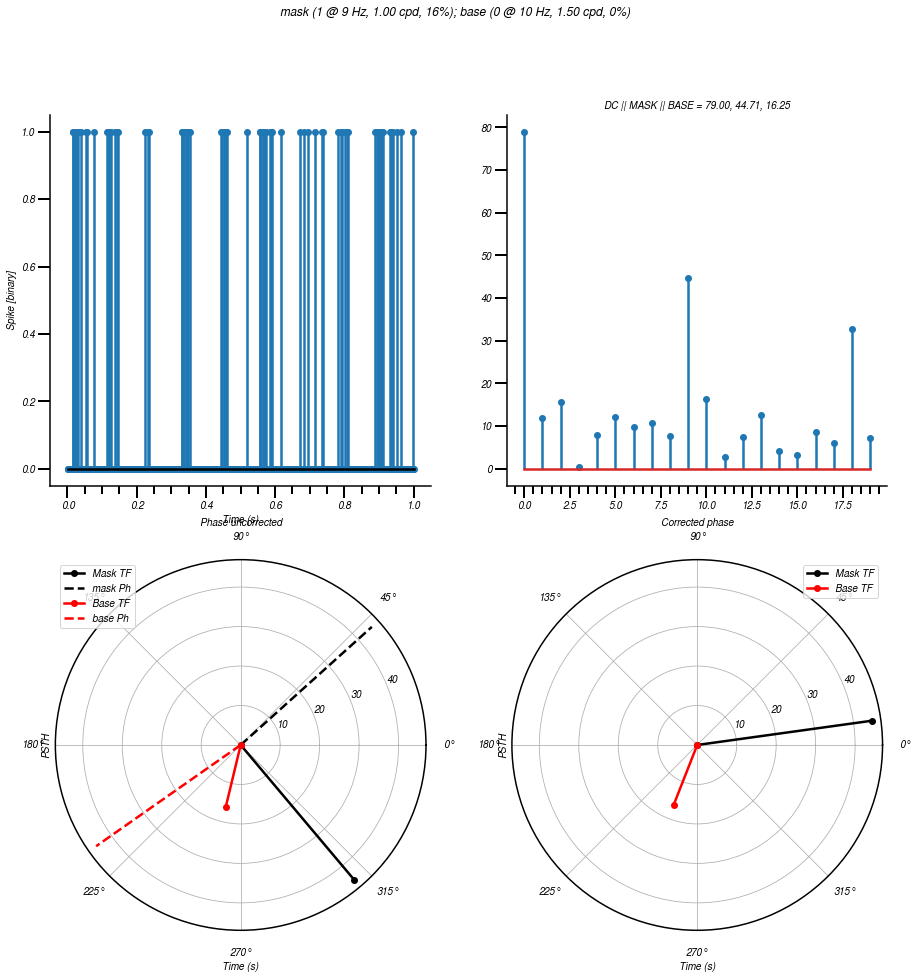

In [465]:
### One trial at a time
# choose a trial
trNum = 512; # 125 is base only; 512 is strong mask only; # 214 is good both
msTenthToS = 1e-4; # the spike times are in 1/10th ms, so multiply by 1e-4 to convert to S
spikeTimes = expInfo['spikeTimes'][trNum]*msTenthToS
# fixed
stimDur = 1

# -- get stimulus info
maskInd, baseInd = hf_sf.get_mask_base_inds();
maskO, baseO = byTrial['maskOn'][trNum], byTrial['baseOn'][trNum]
baseTf, maskTf = byTrial['tf'][baseInd, trNum], byTrial['tf'][maskInd, trNum]
basePh, maskPh = byTrial['ph'][baseInd, trNum], byTrial['ph'][maskInd, trNum]
baseSf, maskSf = byTrial['sf'][baseInd, trNum], byTrial['sf'][maskInd, trNum]
baseCon, maskCon = byTrial['con'][baseInd, trNum], byTrial['con'][maskInd, trNum]

# -- compute PSTH
psth, bins = hf.make_psth([spikeTimes], stimDur=stimDur)
tfAsInts = np.zeros((2,), dtype='int32')
tfAsInts[maskInd] = int(maskTf)
tfAsInts[baseInd] = int(baseTf)
amps, rel_amps, full_fourier = hf.spike_fft([psth], tfs = [tfAsInts], stimDur = stimDur)

# Plot spike times, cycle averaged PSTH
plt.subplots(2, 2, figsize=(15, 15));

plt.suptitle('mask (%d @ %d Hz, %.2f cpd, %d%%); base (%d @ %d Hz, %.2f cpd, %d%%)' % (maskO, maskTf, maskSf, np.round(100*maskCon), 
                                                                                  baseO, baseTf, baseSf, np.round(100*baseCon)));

plt.subplot(2,2,1)
plt.stem(bins[0][1:], psth[0], basefmt='k')
plt.ylabel('Spike [binary]')
plt.xlabel('Time (s)')

# get the (R,phi) for the mask & base components
vec_mask, vec_base = full_fourier[0][0][tfAsInts[maskInd]], full_fourier[0][0][tfAsInts[baseInd]]
r_mask, phi_mask = np.abs(vec_mask), np.angle(vec_mask, deg=True) # will be in deg
r_base, phi_base = np.abs(vec_base), np.angle(vec_base, deg=True) # in deg

plt.subplot(2,2,2);
max_f = 2*np.max(tfAsInts)
plt.stem(amps[0][0][0:max_f])
plt.title('DC || MASK || BASE = %.2f, %.2f, %.2f' % (amps[0][0][0], amps[0][0][tfAsInts[maskInd]], amps[0][0][tfAsInts[baseInd]]));

plt.subplot(2,2,3, projection='polar');
plt.plot([0, np.deg2rad(phi_mask)], [0, r_mask], 'o-k', label='Mask TF')
plt.plot([0, np.deg2rad(maskPh)], [0, r_mask], '--k', label='mask Ph')
plt.plot([0, np.deg2rad(phi_base)], [0, r_base], 'o-r', label='Base TF')
plt.plot([0, np.deg2rad(basePh)], [0, r_mask], '--r', label='base Ph')
plt.ylabel('PSTH')
plt.xlabel('Time (s)')
plt.title('Phase uncorrected')
plt.legend();

plt.subplot(2,2,4, projection='polar');
dir = -1;
maskPh_relStim = np.mod(np.multiply(dir, np.add(phi_mask, maskPh)), 360);
basePh_relStim = np.mod(np.multiply(dir, np.add(phi_base, basePh)), 360);
plt.plot([0, np.deg2rad(maskPh_relStim)], [0, r_mask], 'o-k', label='Mask TF')
plt.plot([0, np.deg2rad(basePh_relStim)], [0, r_base], 'o-r', label='Base TF')
plt.ylabel('PSTH')
plt.xlabel('Time (s)')
plt.title('Corrected phase')
plt.legend();


In [626]:
expInfo.keys()

dict_keys(['trial', 'spikeTimes', 'spikeCounts', 'f1_mask', 'f1_base', 'blank', 'base', 'maskSF', 'baseSF', 'maskCon', 'baseCon'])

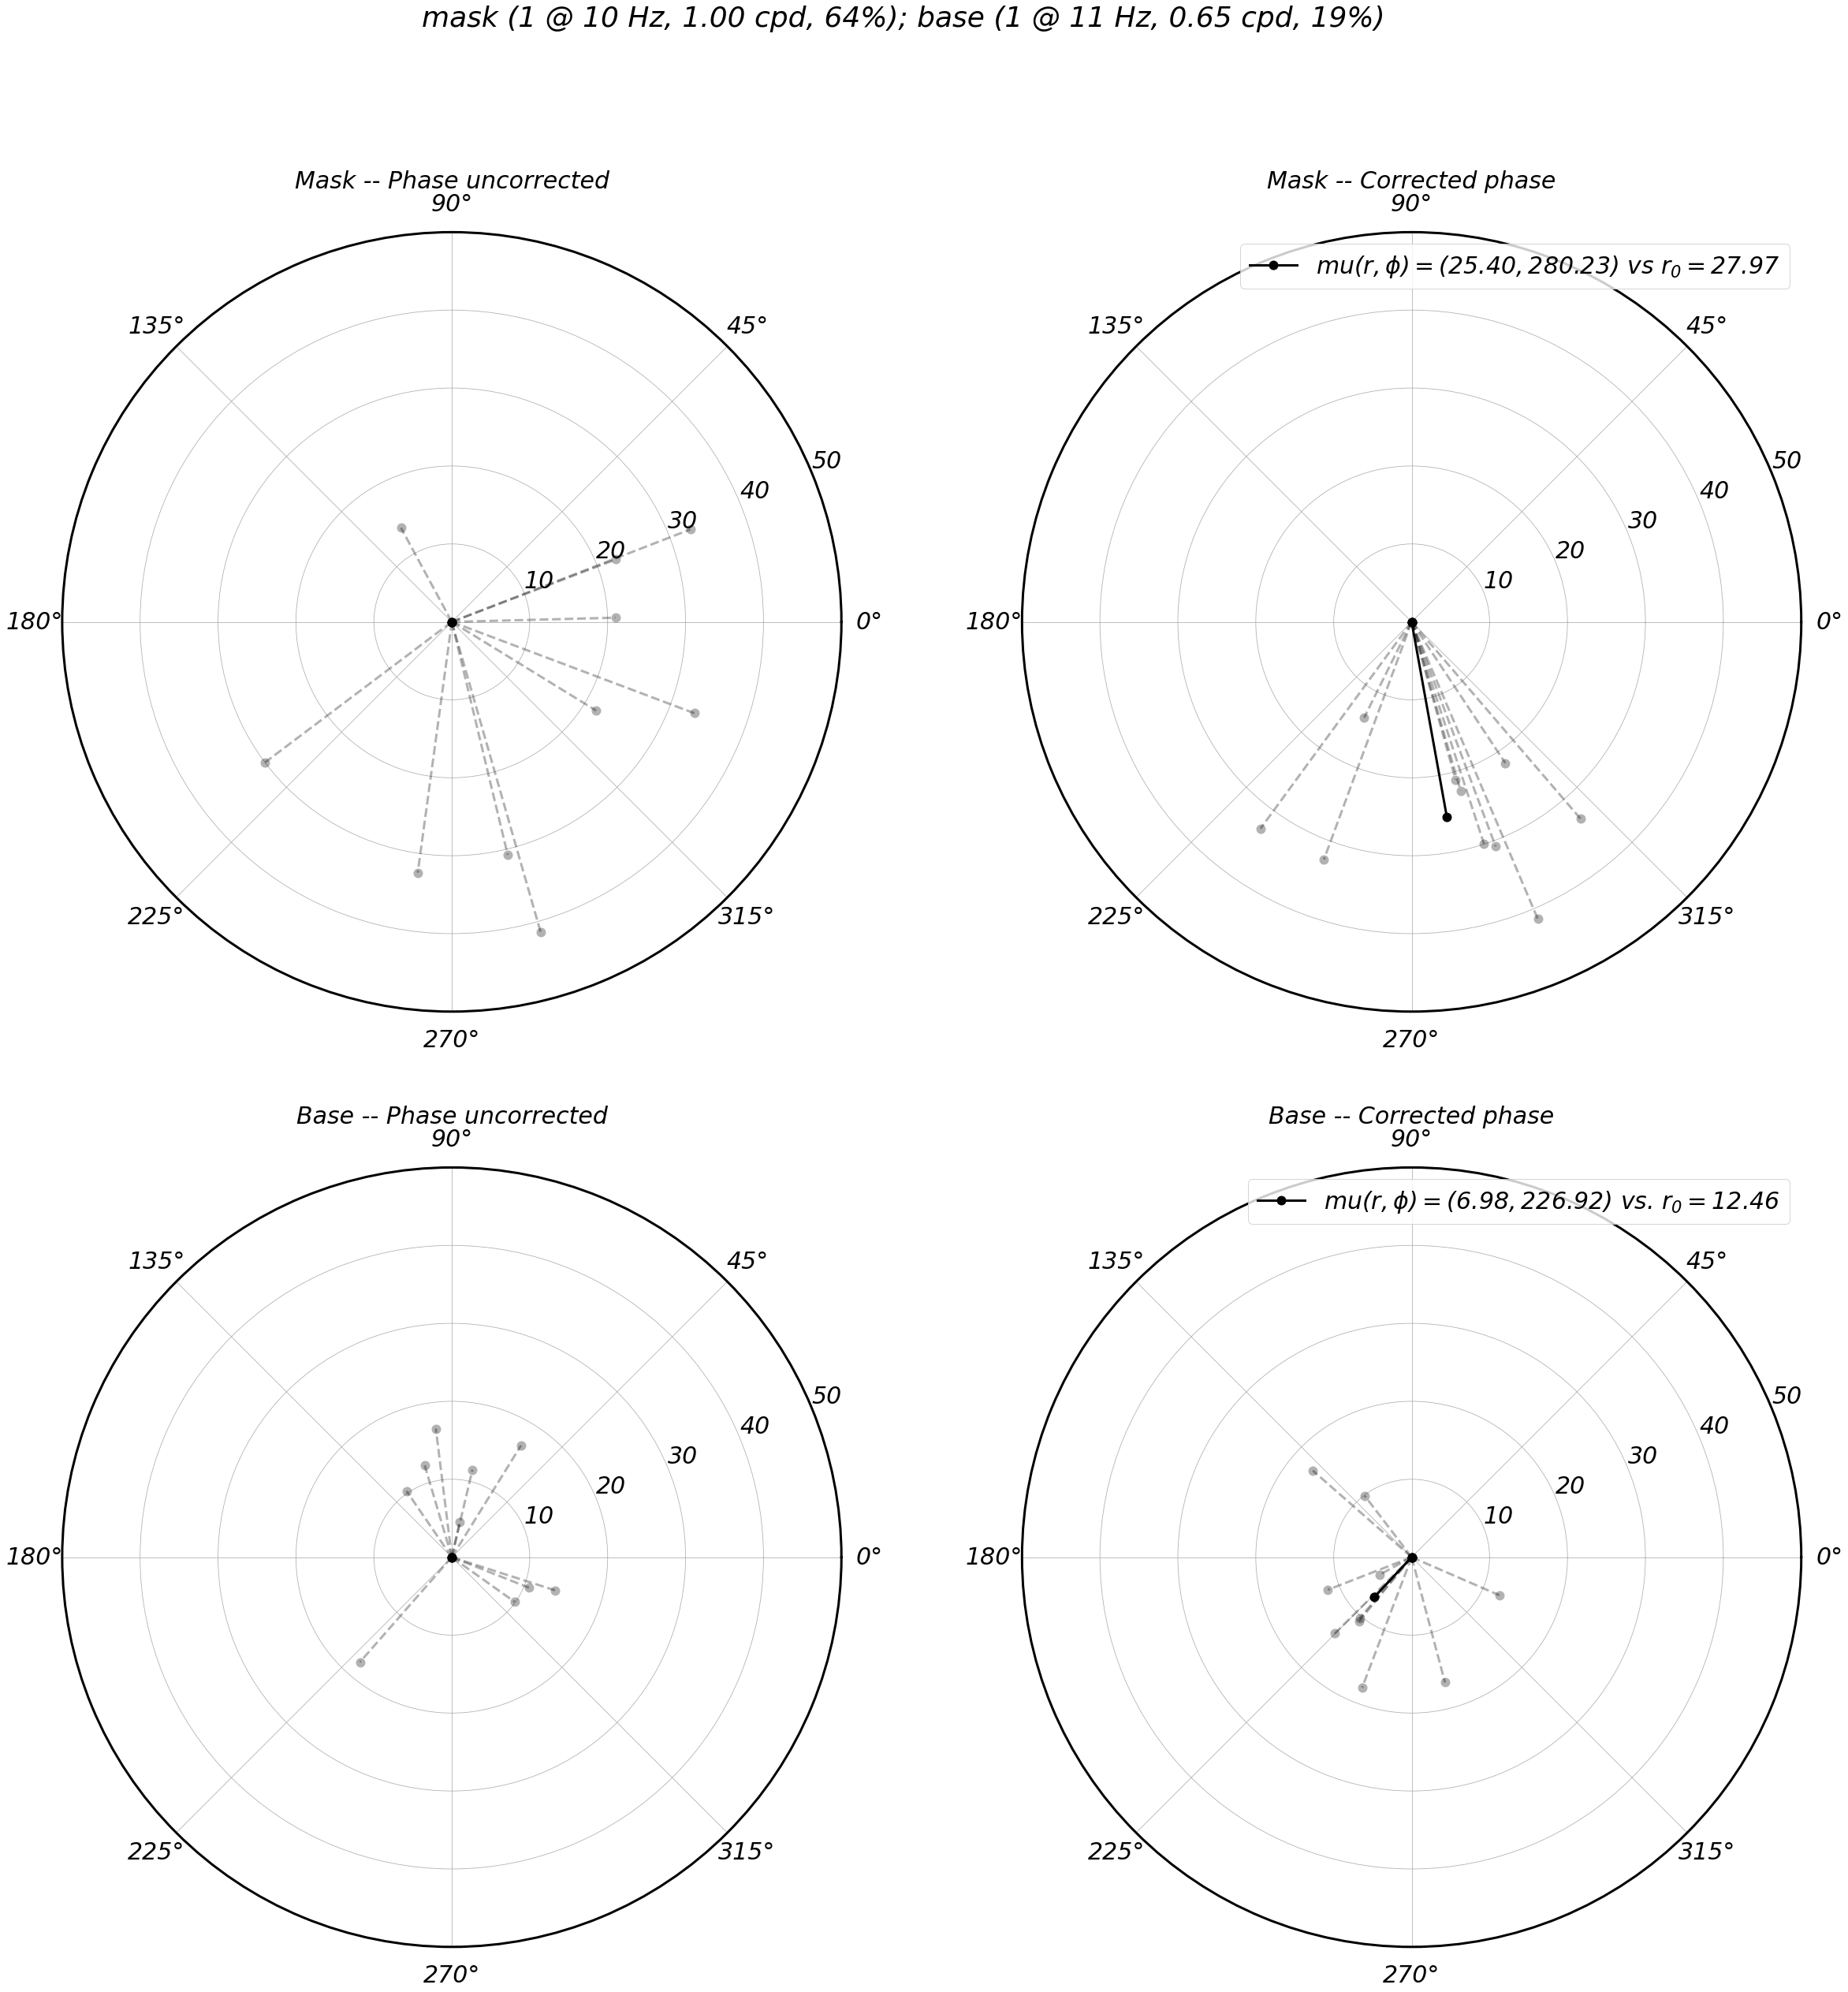

In [646]:
### All trials of the same condition
# fixed
dir = -1;
stimDur = 1
conDig = 2
maskInd, baseInd = hf_sf.get_mask_base_inds();
# Choose which condition to consider
maskOn, baseOn = 1, 1;
whichCon, whichSf = -1, 3;
# Gather all possible stimulus conditions
maskSfs = expInfo['maskSF'];
maskCons = np.round(expInfo['maskCon'], conDig);

# find the right trials
whichComps = np.logical_and(byTrial['maskOn']==maskOn, byTrial['baseOn']==baseOn)
whichSfs = byTrial['sf'][maskInd, :] == maskSfs[whichSf]
whichCons = np.round(byTrial['con'][maskInd, :], conDig) == maskCons[whichCon]
val_trials = np.where(np.logical_and(whichComps, np.logical_and(whichSfs, whichCons)))[0]

# organize the spikes
msTenthToS = 1e-4; # the spike times are in 1/10th ms, so multiply by 1e-4 to convert to S
spikeTimes = [expInfo['spikeTimes'][trNum]*msTenthToS for trNum in val_trials]

# -- get stimulus info
baseTf, maskTf = byTrial['tf'][baseInd, val_trials], byTrial['tf'][maskInd, val_trials]
basePh, maskPh = byTrial['ph'][baseInd, val_trials], byTrial['ph'][maskInd, val_trials]
baseSf, maskSf = byTrial['sf'][baseInd, val_trials], byTrial['sf'][maskInd, val_trials]
baseCon, maskCon = byTrial['con'][baseInd, val_trials], byTrial['con'][maskInd, val_trials]

# -- compute PSTH
psth, bins = hf.make_psth(spikeTimes, stimDur=stimDur)
tfAsInts = np.zeros((len(val_trials),2), dtype='int32')
tfAsInts[:, maskInd] = maskTf;
tfAsInts[:, baseInd] = baseTf;
amps, rel_amps, full_fourier = hf.spike_fft(psth, tfs = tfAsInts, stimDur = stimDur)

resp_phase = np.array([np.angle(full_fourier[x][tfAsInts[x, :]], True) for x in range(len(full_fourier))]); # true --> in degrees                                                          
resp_amp = np.array([amps[tfAsInts[ind, :]] for ind, amps in enumerate(amps)]); # after correction of amps (19.08.06)                                                                   
stimPhs = np.zeros_like(resp_amp);
stimPhs[:, maskInd] = maskPh
stimPhs[:, baseInd] = basePh

phase_rel_stim = np.mod(np.multiply(dir, np.add(resp_phase, stimPhs)), 360);
mean_r, mean_phi, _, _ = hf.polar_vec_mean(np.transpose(resp_amp), np.transpose(phase_rel_stim))
uncorr_r = np.mean(rel_amps, axis=0);

max_r = 10*np.ceil(np.max(resp_amp)/10) # round to the nearest multiple of 10

# Plot spike times, cycle averaged PSTH
f, ax = plt.subplots(2, 2, figsize=(40, 40));

f.suptitle('mask (%d @ %d Hz, %.2f cpd, %d%%); base (%d @ %d Hz, %.2f cpd, %d%%)' % (maskOn, np.unique(maskTf), np.unique(maskSf), np.unique(np.round(100*maskCon)), 
                                                                                  baseOn, np.unique(baseTf), np.unique(baseSf), np.unique(np.round(100*baseCon))));

# MASK (will do base component after)
plt.subplot(2,2,1, projection='polar');
[plt.plot([0, np.deg2rad(phi)], [0, r], 'o--k', alpha=0.3) for phi,r in zip(resp_phase[:, maskInd], resp_amp[:, maskInd])]
plt.title('Mask -- Phase uncorrected')
plt.ylim([0, max_r])

plt.subplot(2,2,2, projection='polar');
[plt.plot([0, np.deg2rad(phi)], [0, r], 'o--k', alpha=0.3) for phi,r in zip(phase_rel_stim[:, maskInd], resp_amp[:, maskInd])]
curr_r, curr_phi = mean_r[maskInd], mean_phi[maskInd]
plt.plot([0, np.deg2rad(curr_phi)], [0, curr_r], 'o-k', label=r'$ mu(r,\phi) = (%.2f, %.2f)$ vs $r_0 = %.2f$' % (curr_r, curr_phi, uncorr_r[maskInd]))
plt.title('Mask -- Corrected phase')
plt.ylim([0, max_r])
plt.legend();

# BASE
plt.subplot(2,2,3, projection='polar');
[plt.plot([0, np.deg2rad(phi)], [0, r], 'o--k', alpha=0.3) for phi,r in zip(resp_phase[:, baseInd], resp_amp[:, baseInd])]
plt.title('Base -- Phase uncorrected')
plt.ylim([0, max_r])

plt.subplot(2,2,4, projection='polar');
[plt.plot([0, np.deg2rad(phi)], [0, r], 'o--k', alpha=0.3) for phi,r in zip(phase_rel_stim[:, baseInd], resp_amp[:, baseInd])]
curr_r, curr_phi = mean_r[baseInd], mean_phi[baseInd]
plt.plot([0, np.deg2rad(curr_phi)], [0, curr_r], 'o-k', label=r'$ mu(r,\phi) = (%.2f, %.2f)$ vs. $r_0 = %.2f$' % (curr_r, curr_phi, uncorr_r[baseInd]))
plt.title('Base -- Corrected phase')
plt.ylim([0, max_r])
plt.legend();

saveName = "/cell_%03d_phaseCorr_sf%03d_con%03d_b%d_m%d.pdf" % (cellNum, np.int(100*np.unique(maskSf)), np.int(100*np.unique(maskCon)), maskOn, baseOn)

full_save = os.path.dirname(str(save_loc + 'phase_corr/%s/cell_%03d/' % (expName, cellNum)));
if not os.path.exists(full_save):
    os.makedirs(full_save);
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f)
# plt.close(f)
pdfSv.close()



## Onset transient correction
Per Tony & Eero, our F1 amplitudes might be biased by the onset transient. To diagnose the extent of this issue, we'll do the following:

1. Create an all-trials PSTH for each cell. Since our stimuli randomize phase, the mean PSTH response should be flat across time _except_ for the onset transient. This will help us diagnose the strength and characteristic (i.e. shape, time) of the onset transient. We expect that the onset transient $\vec{T}$ will be unique for each cell, but likely
2. The model we then use to measure the _true_ underlying response (DC, F1 at mask TF, F1 at base TF) is the following:

$$ (\vec{M} = [\vec{1}, \vec{T}, \sin{t_m}, \cos{t_m}, \sin{t_b}, \cos{t_b}]) * \vec{W} = \vec{R}$$

where the columns of matrix on the left represent the DC, transient, mask frequency sin/cos, and base frequency sin/cos; $\vec{W}$ is the set of weights on those matrix columns; and $\vec{R}$ is the PSTH. This will be done as a discrete Fourier transform, with a specified bin size (e.g. 1 ms), and can be solved by simple matrix inversion, i.e.

$$ \vec{W} = \vec{R}*\vec{M^{-1}} $$

where $\vec{M}$ is [nBins x 6], $\vec{W}$ = [6 x 1], and $\vec{R}$ = [nBins x 1]

In [29]:
from scipy.stats import truncnorm, poisson

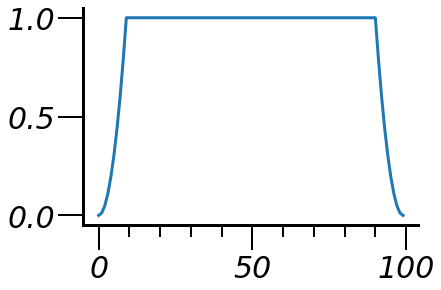

In [77]:
# 10 ms to get to max
# 10 ms to decay to 0
nBins = len(onset_bins)
triFilt = np.ones_like(onset_bins)
onCut = int(0.1*nBins);
triFilt[0:onCut] = np.square(np.linspace(0,1,onCut))
triFilt[nBins-onCut:nBins] = np.square(np.linspace(1,0,onCut))
plt.plot(triFilt)

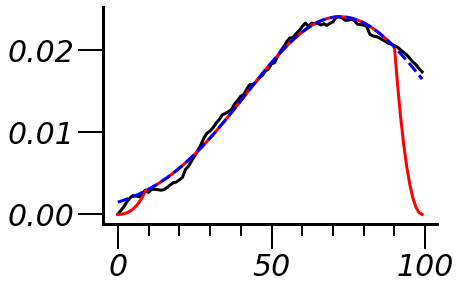

In [112]:
msTenthToS = 1e-4; # the spike times are in 1/10th ms, so multiply by 1e-4 to convert to S
nonBlank = np.where(np.logical_or(byTrial['maskOn'], byTrial['maskOn']))[0]
nTrials = len(nonBlank);
# print('%d non-blank trials considered' % nTrials);
allSpikes = np.hstack(expInfo['spikeTimes'][nonBlank] * msTenthToS)

halfWidth = 20; # in mS
psth, bins = hf.make_psth_slide([allSpikes], binWidth=halfWidth*1e-3);
psth = psth[0];
rate = psth/nTrials;

max_rate = np.max(psth);

onsetInd = int((1e-3*onsetWidth/stimDur)*len(psth));
onset_rate, onset_bins = rate[0:onsetInd], bins[0:onsetInd]
onset_toFit = onset_rate - np.min(rate);

plt.plot(1e3*onset_bins, onset_toFit, 'k-')

loss = lambda prms: np.sum(np.square(my_truncnorm(*prms, 1e3*onset_bins) - onset_toFit))
init_fit = [0.2,50,10]
best_fit = opt.minimize(loss, init_fit)

plt.plot(1e3*onset_bins, triFilt*my_truncnorm(*best_fit['x'], 1e3*onset_bins), 'r-')
plt.plot(1e3*onset_bins, my_truncnorm(*best_fit['x'], 1e3*onset_bins), 'b--')

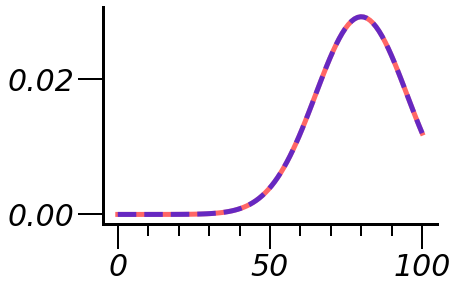

In [106]:
# set here
a, b = 0, 100
loc=80;
scale=15;
# the ncalculate
aEff, bEff = (a - loc) / scale, (b - loc) / scale

my_truncnorm = lambda amp,loc, scale, x: amp*truncnorm.pdf(x, (a-loc)/scale, (b-loc)/scale, loc=loc, scale=scale);


x = np.linspace(a, b, 100)
plt.plot(x, truncnorm.pdf(x, aEff, bEff, loc=loc, scale=scale),
       'r-', lw=5, alpha=0.6, label='truncnorm pdf')

plt.plot(x, my_truncnorm(1,loc, scale, x),
       'b--', lw=5, alpha=0.6, label='truncnorm pdf')

In [7]:
autoreload.reload(hf)

<module 'helper_fcns' from '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py'>

In [110]:
# which cell?
cellNum = 19;

# auto...
expDir = 'V1_BB/';
path = '%sstructures/' % expDir;
dataList = hf.np_smart_load(path + 'dataList.npy')

save_loc = '%sfigures/' % expDir;

expName = 'sfBB_core';

unitNm = dataList['unitName'][cellNum-1];
cell = hf.np_smart_load('%s%s_sfBB.npy' % (path, unitNm));
expInfo = cell[expName]
byTrial = expInfo['trial'];

stimDur = 1

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:106: ComplexWarning: Casting complex values to real discards the imaginary part


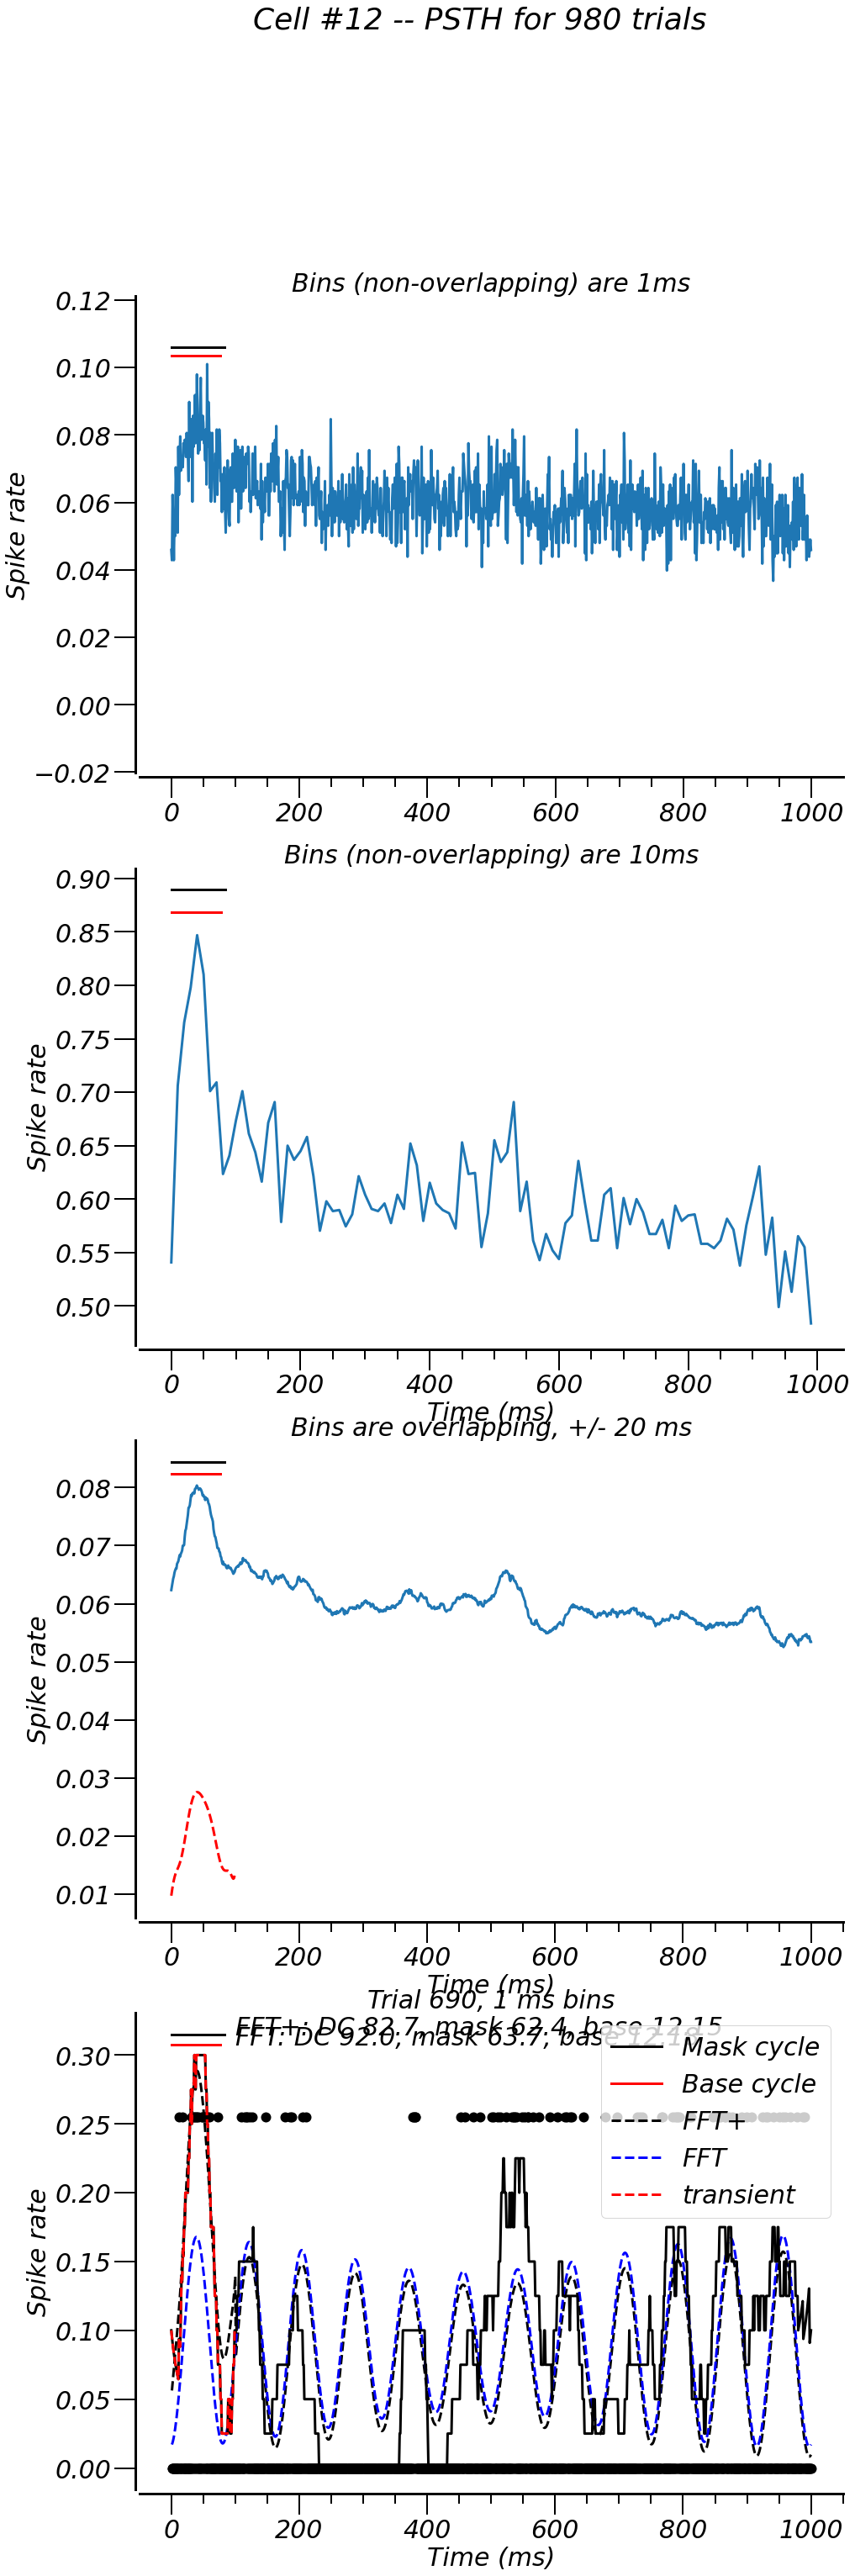

In [95]:
msTenthToS = 1e-4; # the spike times are in 1/10th ms, so multiply by 1e-4 to convert to S
nonBlank = np.where(np.logical_or(byTrial['maskOn'], byTrial['maskOn']))[0]
nTrials = len(nonBlank);
# print('%d non-blank trials considered' % nTrials);
allSpikes = np.hstack(expInfo['spikeTimes'][nonBlank] * msTenthToS)

maskInd, baseInd = hf_sf.get_mask_base_inds();

# what is the length (in mS) of one cycle (mask, base separately)
maskTf = np.unique(expInfo['trial']['tf'][maskInd,:])[0]
baseTf = np.unique(expInfo['trial']['tf'][baseInd,:])[0]
cycleDur_mask = 1e3/maskTf # guaranteed only one TF value
cycleDur_base = 1e3/baseTf # guaranteed only one TF value

nrow, ncol = 4, 1
f, ax = plt.subplots(nrow, ncol, figsize=(ncol*15, nrow*12))

f.suptitle('Cell #%d -- PSTH for %d trials' % (cellNum, nTrials))

# 1 ms bins
psth, bins = hf.make_psth([allSpikes], binWidth=1e-3)
rate = psth[0]/nTrials;
# - init params (we'll fit a Gaussian to the first X ms)
toFit = 100; # in mS

psth_floor = np.min(rate);
wherePeak = np.argmax(rate);
# -- fit PSTH

max_rate = np.max(rate)
ax[0].plot([0, cycleDur_mask], [1.05*max_rate, 1.05*max_rate], 'k-', label='Mask cycle')
ax[0].plot([0, cycleDur_base], [1.025*max_rate, 1.025*max_rate], 'r-', label='Base cycle')
ax[0].plot(1e3*bins[0][0:-1], rate); # put times in mS
ax[0].set_ylim([-0.2*max_rate, 1.2*max_rate])
ax[0].set_ylabel('Spike rate');
# ax[0].set_xlabel('Time (ms)');
ax[0].set_title('Bins (non-overlapping) are 1ms');

# 10 ms bins
psth, bins = hf.make_psth([allSpikes], binWidth=1e-2)
rate = psth[0]/nTrials;
# - init params
psth_floor = np.min(rate);
# wherePeak = np.argmax(rate);
# init_params = [0.050,0.05,0.011,1.2*psth_floor];
init_params = [0.50,0.001,0.001,1.2*psth_floor];

max_rate = np.max(rate);
ax[1].plot([0, cycleDur_mask], [1.05*max_rate, 1.05*max_rate], 'k-', label='Mask cycle')
ax[1].plot([0, cycleDur_base], [1.025*max_rate, 1.025*max_rate], 'r-', label='Base cycle')
ax[1].plot(1e3*bins[0][0:-1], rate); # put times in mS
ax[1].set_ylabel('Spike rate');
# ax[1].set_ylim([-0.2*max_rate, 1.2*max_rate])
ax[1].set_xlabel('Time (ms)');
ax[1].set_title('Bins (non-overlapping) are 10ms');

# X (e.g. 25) ms SLIDING bins (will take longer)
halfWidth = 20; # in mS
psth, bins = hf.make_psth_slide([allSpikes], binWidth=halfWidth*1e-3);
psth = psth[0];
rate = psth/nTrials;

# Fit onset transient...
onsetWidth = 100;
full_transient = hf.fit_onset_transient(rate, bins, onsetWidth=onsetWidth, toNorm=0)
max_rate = np.max(rate);
onsetInd = int((1e-3*onsetWidth/stimDur)*len(psth));
onset_rate, onset_bins = rate[0:onsetInd], bins[0:onsetInd]

ax[2].plot([0, cycleDur_mask], [1.05*max_rate, 1.05*max_rate], 'k-', label='Mask cycle')
ax[2].plot([0, cycleDur_base], [1.025*max_rate, 1.025*max_rate], 'r-', label='Base cycle')
ax[2].plot(1e3*bins, rate); # put times in mS
ax[2].plot(1e3*onset_bins, full_transient[0:onsetInd], 'r--')
ax[2].set_ylabel('Spike rate');
# ax[1].set_ylim([-0.2*max_rate, 1.2*max_rate])
ax[2].set_xlabel('Time (ms)');
ax[2].set_title('Bins are overlapping, +/- %d ms' % halfWidth);

#################
### Now, just the PSTH for one trial
#################

##### pick trial
#whichTrial = 705; # good examples for cell #12: 10, 100, 560 (best), 561, 569
whichTrial = 690; # good examples for cell #4: 705, 274, 862, 
##### pick trial

curr_spikes = expInfo['spikeTimes'][whichTrial-1] * msTenthToS
psth, bins = hf.make_psth_slide([curr_spikes], binWidth=halfWidth*1e-3)
psth = psth[0];
psth_raw, bins_raw = hf.make_psth([curr_spikes], binWidth=1e-3)
psth_raw = psth_raw[0]; bins_raw = bins_raw[0];

### Actually get the FFT coefficients??
input_mat, coeffs, spectrum, amplitudes = hf.manual_fft(psth_raw, tfs=np.array([int(maskTf), int(baseTf)]), onsetTransient=full_transient)
input_mat_noTransient, coeffs_noTransient, spectrum_noTr, amplitudes_noTr = hf.manual_fft(psth_raw, tfs=np.array([int(maskTf), int(baseTf)]), onsetTransient=None)

max_rate = np.max(psth);

onsetInd = int((1e-3*onsetWidth/stimDur)*len(psth));
onset_rate, onset_bins = psth[0:onsetInd], bins[0:onsetInd]
onset_toFit = onset_rate - np.min(rate);

# compute amplitudes - first from real FFT, then our manual FFT*
_, tf_amps, amps = hf.spike_fft([psth_raw], tfs=[[int(maskTf), int(baseTf)]], stimDur=1)
ax[3].text(cycleDur_mask*1.2, 1.025*max_rate, 'FFT: DC %.1f, mask %.1f, base %.2f' % (amps[0][0], tf_amps[0][0], tf_amps[0][1]))
ax[3].text(cycleDur_mask*1.2, 1.05*max_rate, 'FFT+: DC %.1f, mask %.1f, base %.2f' % (amplitudes[0], amplitudes[1], amplitudes[2]))

ax[3].plot([0, cycleDur_mask], [1.05*max_rate, 1.05*max_rate], 'k-', label='Mask cycle')
ax[3].plot([0, cycleDur_base], [1.025*max_rate, 1.025*max_rate], 'r-', label='Base cycle')
# plot the fit??
ax[3].plot(1e3*bins[1:], np.matmul(input_mat, coeffs), 'k--', label='FFT+')
ax[3].plot(1e3*bins[1:], np.matmul(input_mat_noTransient, coeffs_noTransient), 'b--', label='FFT')

ax[3].plot(1e3*bins_raw[1:], .85*max_rate*psth_raw, 'ko'); # put times in mS
ax[3].plot(1e3*bins, psth, 'k-'); # put times in mS
ax[3].plot(1e3*onset_bins, onset_rate[0:onsetInd], 'r--', label='transient')
ax[3].set_ylabel('Spike rate');
# ax[1].set_ylim([-0.2*max_rate, 1.2*max_rate])
ax[3].set_xlabel('Time (ms)');
ax[3].set_title('Trial %d, 1 ms bins' % whichTrial);
ax[3].legend();

sns.despine(offset=5)

In [1896]:
print('FFT: DC %.1f, mask %.1f, base %.2f' % (amps[0][0], tf_amps[0][0], tf_amps[0][1]))
print('FFT+: DC %.1f, mask %.1f, base %.2f' % (amplitudes[0], amplitudes[1], amplitudes[2]))


FFT: DC 109.0, mask 86.1, base 17.27
FFT+: DC 106.5, mask 86.1, base 17.62


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


##### Let's make the polar plots to see the effect of modelling the onset transient

In [2016]:
# Load the datalist, given cell
cellNum = 19; # 4 is a simple cell, so that's a good choice
expDir = 'V1_BB/';
path = '%sstructures/' % expDir;
dataList = hf.np_smart_load(path + 'dataList.npy')

expName = 'sfBB_core';

unitNm = dataList['unitName'][cellNum-1];
cell = hf.np_smart_load('%s%s_sfBB.npy' % (path, unitNm));
expInfo = cell[expName]
byTrial = expInfo['trial'];

# Set the onset parameters, load accordingly
onsetDur = 150; # in mS, how long is the onset that we should model
halfWidth = 15; # in mS, how wide (in one direction rel. to center) is the smoothing window for the PSTH from which we model the onset?
onset_key = (onsetDur, halfWidth)
onset_name = 'onset_transients.npy'
onsets = hf.np_smart_load(path + onset_name);
curr_transient = onsets[cellNum-1][onset_key]['transient']

Saving V1_BB/figures/phase_corr_wOnset/sfBB_core/cell_019_150_015/both/cell_019_phaseCorr_sf100_con063.pdf


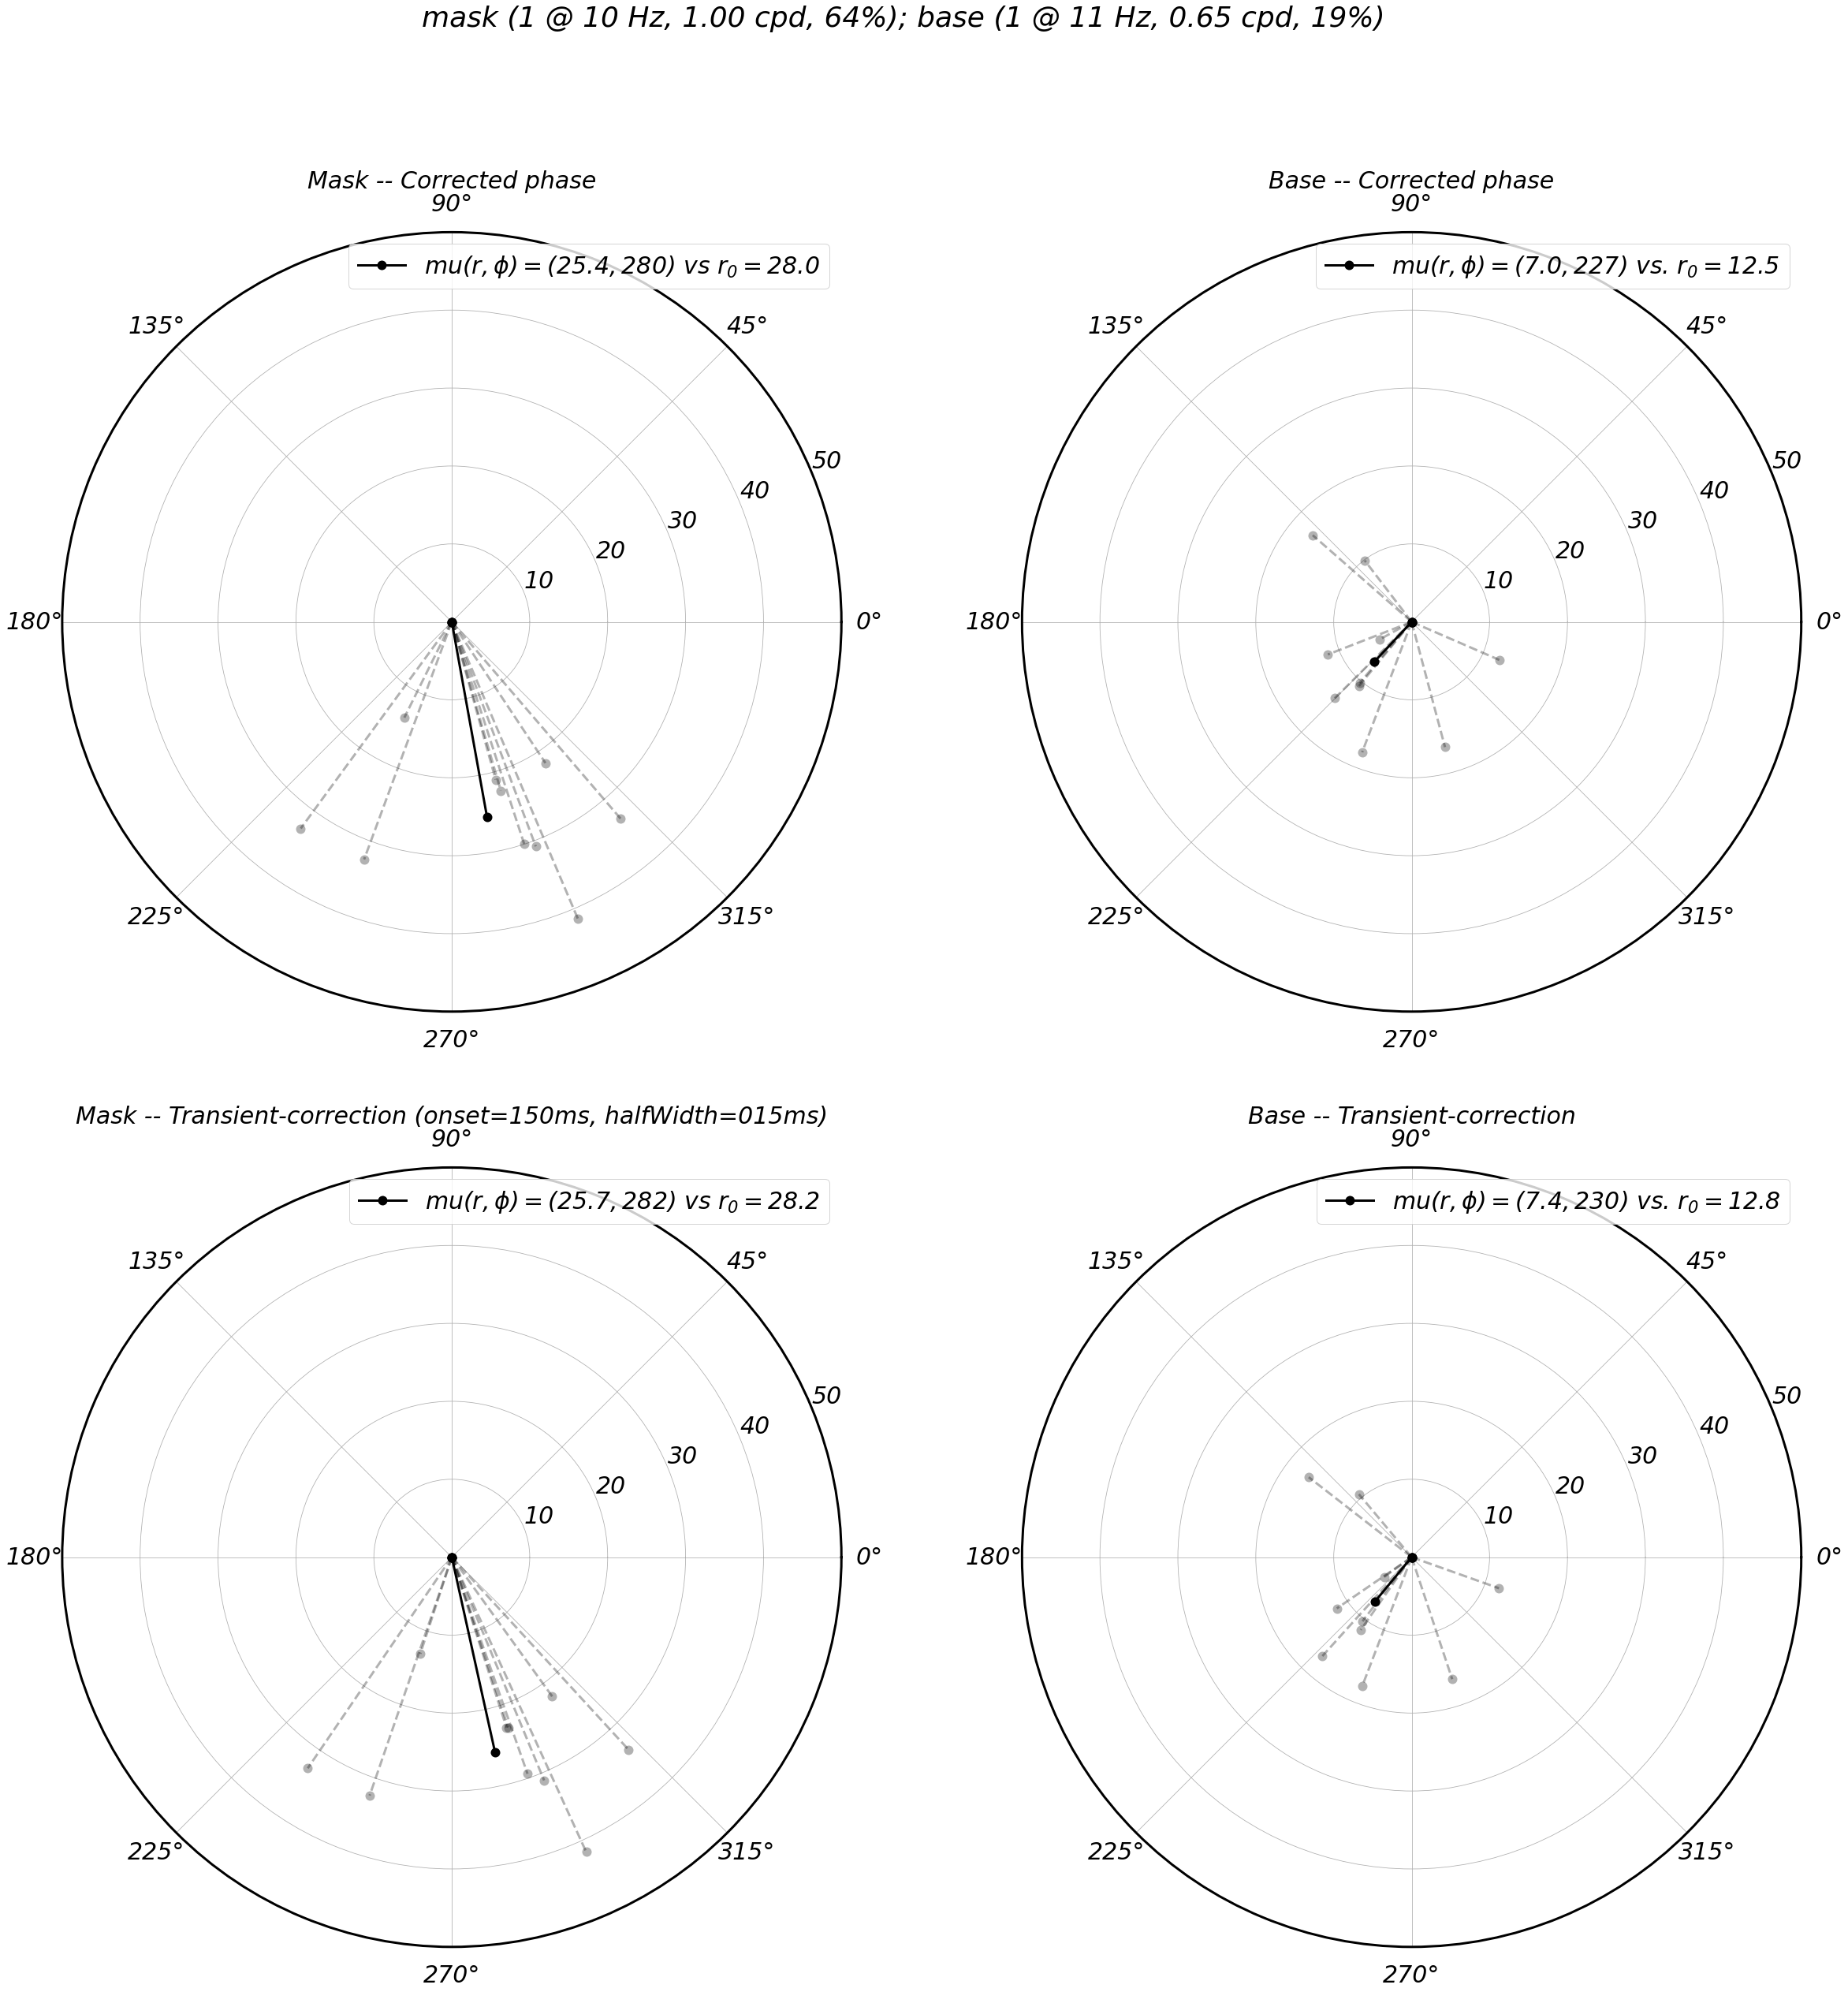

In [2017]:
# fixed
dir = -1;
stimDur = 1
conDig = 2
maskInd, baseInd = hf_sf.get_mask_base_inds();
# Choose which condition to consider
maskOn, baseOn = 1, 1;
whichCon, whichSf = -1, 3;

# Choose which condition to consider                                                                                                                                                                                                                                
val_trials, stimPh, stimTf = hf_sf.get_valid_trials(expInfo, maskOn, baseOn, whichCon, whichSf, returnStimConds=1);
# Then get the vec avg'd responses, phase information, etc                                                                                                                                                                                                   
vec_avgs, vec_byTrial, rel_amps, _, _, _ = hf_sf.get_vec_avg_response(expInfo, val_trials, dir=dir, stimDur=stimDur);
# - unpack the vec_avgs, and per trial                                                                                                                                                                                                                              
mean_r, mean_phi = vec_avgs[0], vec_avgs[1];
resp_amp, phase_rel_stim = vec_byTrial[0], vec_byTrial[1];
# -- average the uncorrected amplitudes...                                                                                                                                                                                                                          
uncorr_r = np.mean(rel_amps, axis=0);
# - and unpack the stimTF...(NOTE: suptitle call assumes only one TF value for mask, base, respectively)                                                                                                                                                            
maskTf = stimTf[:, maskInd];
baseTf = stimTf[:, baseInd];

max_r = 10*np.ceil(np.max(resp_amp)/10) # round to the nearest multiple of 10                                                                                                                                                                                       

# Plot spike times, cycle averaged PSTH                                                                                                                                                                                                                             
nrow = 2; ncol = 2;
f, ax = plt.subplots(nrow, ncol, figsize=(ncol*20, nrow*20));

f.suptitle('mask (%d @ %d Hz, %.2f cpd, %d%%); base (%d @ %d Hz, %.2f cpd, %d%%)' % (maskOn, np.unique(maskTf), np.unique(maskSf)[0], np.unique(np.round(100*maskCon))[0],
                                                                                baseOn, np.unique(baseTf), np.unique(baseSf)[0], np.unique(np.round(100*baseCon))[0]));

# MASK (will do base component after)                                                                                                                                                                                                                               
plt.subplot(nrow,ncol,1, projection='polar');
[plt.plot([0, np.deg2rad(phi)], [0, r], 'o--k', alpha=0.3) for phi,r in zip(phase_rel_stim[:, maskInd], resp_amp[:, maskInd])]
curr_r, curr_phi = mean_r[maskInd], mean_phi[maskInd]
plt.plot([0, np.deg2rad(curr_phi)], [0, curr_r], 'o-k', label=r'$ mu(r,\phi) = (%.1f, %.0f)$ vs $r_0 = %.1f$' % (curr_r, curr_phi, uncorr_r[maskInd]))
plt.title('Mask -- Corrected phase')
plt.ylim([0, max_r])
plt.legend(fontsize='medium');

# BASE                                                                                                                                                                                                                                                              
plt.subplot(nrow,ncol,2, projection='polar');
[plt.plot([0, np.deg2rad(phi)], [0, r], 'o--k', alpha=0.3) for phi,r in zip(phase_rel_stim[:, baseInd], resp_amp[:, baseInd])]
curr_r, curr_phi = mean_r[baseInd], mean_phi[baseInd]
plt.plot([0, np.deg2rad(curr_phi)], [0, curr_r], 'o-k', label=r'$ mu(r,\phi) = (%.1f, %.0f)$ vs. $r_0 = %.1f$' % (curr_r, curr_phi, uncorr_r[baseInd]))
plt.title('Base -- Corrected phase')
plt.ylim([0, max_r])
plt.legend(fontsize='medium');

#### Now, do the transient/manual FFT stuff
# Then get the vec avg'd responses, phase information, etc                                                                                                                                                                                                   
vec_avgs, vec_byTrial, rel_amps, _, _, _ = hf_sf.get_vec_avg_response(expInfo, val_trials, dir=dir, stimDur=stimDur, onsetTransient=curr_transient);
# - unpack the vec_avgs, and per trial                                                                                                                                                                                                                              
mean_r, mean_phi = vec_avgs[0], vec_avgs[1];
resp_amp, phase_rel_stim = vec_byTrial[0], vec_byTrial[1];
# -- average the uncorrected amplitudes...                                                                                                                                                                                                                          
uncorr_r = np.mean(rel_amps, axis=0);

# MASK (will do base component after)                                                                                                                                                                                                                               
plt.subplot(nrow,ncol,3, projection='polar');
[plt.plot([0, np.deg2rad(phi)], [0, r], 'o--k', alpha=0.3) for phi,r in zip(phase_rel_stim[:, maskInd], resp_amp[:, maskInd])]
curr_r, curr_phi = mean_r[maskInd], mean_phi[maskInd]
plt.plot([0, np.deg2rad(curr_phi)], [0, curr_r], 'o-k', label=r'$ mu(r,\phi) = (%.1f, %.0f)$ vs $r_0 = %.1f$' % (curr_r, curr_phi, uncorr_r[maskInd]))
plt.title('Mask -- Transient-correction (onset=%03dms, halfWidth=%03dms)' % (onsetDur, halfWidth))
plt.ylim([0, max_r])
plt.legend(fontsize='medium');

# BASE                                                                                                                                                                                                                                                              
plt.subplot(nrow,ncol,4, projection='polar');
[plt.plot([0, np.deg2rad(phi)], [0, r], 'o--k', alpha=0.3) for phi,r in zip(phase_rel_stim[:, baseInd], resp_amp[:, baseInd])]
curr_r, curr_phi = mean_r[baseInd], mean_phi[baseInd]
plt.plot([0, np.deg2rad(curr_phi)], [0, curr_r], 'o-k', label=r'$ mu(r,\phi) = (%.1f, %.0f)$ vs. $r_0 = %.1f$' % (curr_r, curr_phi, uncorr_r[baseInd]))
plt.title('Base -- Transient-correction')
plt.ylim([0, max_r])
plt.legend(fontsize='medium');

saveName = "/cell_%03d_phaseCorr_sf%03d_con%03d.pdf" % (cellNum, np.int(100*np.unique(maskSf)), np.int(100*np.unique(maskCon)))

if maskOn and baseOn:
    subdir = 'both';
elif maskOn:
    subdir = 'maskOnly';
elif baseOn:
    subdir = 'baseOnly';
    
full_save = os.path.dirname(str(save_loc + 'phase_corr_wOnset/%s/cell_%03d_%03d_%03d/%s/' % (expName, cellNum, onsetDur, halfWidth, subdir)));
if not os.path.exists(full_save):
    os.makedirs(full_save);
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f)
#print('Saving %s' % (full_save + saveName));
# plt.close(f)
pdfSv.close()


## Variance to mean relationship - i.e. Fano Factor
It seems that the Fano factors I've calculated for cells in the sfBB* experiments are very high. This section will look into whether this is correct or if something is amiss...

In [446]:
expDir = 'V1_BB/';
path = '%sstructures/' % expDir;
dataList = hf.np_smart_load(path + 'dataList.npy')

save_loc = '%sfigures/fano/' % expDir;

vecCorrected = 1
onsetCurr = None; # i.e. let's not worry about onset correction

In [433]:
def eval_varGain(varGain, all_counts, count_mean, stimDur, whichCalc = 1):
    ''' all_counts is the spike count from every trial
        count_mean is averaged across condition
    '''
    
    # the model
    # - How does it work? Mu will need to be broadcast to be the same length as all_counts
    # - p is similarly broadcast, while r is just one value
    mu = np.maximum(.1, stimDur * count_mean);     # The predicted mean spike count
    var = mu + (varGain*np.square(mu));          # The corresponding variance of the spike count                                                    
    # Note: Two differeing versions of r - the first (doesn't use var) is from Robbe's code shared through Hasse/Mariana
    # -- the second is from the code that was in early code of my V1 model as written by Robbe
    if whichCalc == 1:
        r  = 1/varGain;
    elif whichCalc == 2:
        r  = np.square(mu) / (var - mu);              # The parameters r and p of the negative binomial distribution
    p  = r / (r + mu);
    # -- Evaluate the model
    llh = nbinom.pmf(all_counts, r, p);        # The likelihood for each pass under the doubly stochastic model
    if np.any(llh==0): # if it's F1 values, we'll round to integer
        llh = nbinom.pmf(np.round(all_counts).astype('int'), r, p);        # The likelihood for each pass under the doubly stochastic model
    NLL = np.sum(-np.log(llh));
    
    return NLL

In [499]:
all_means

array([ 5.32055254,  7.7984354 ,  7.9706675 ,  6.13580093,  8.81952179,
        8.48515675,  7.74079095,  9.31688601,  4.65753356,  7.00319669,
        4.18332115,  4.9971666 ,  7.00656563,  5.30451853,  7.11551131,
        4.62200468,  9.1098088 ,  8.69483687,  6.37006621,  5.32848145,
        7.80807751,  7.56630054,  9.50907293, 10.9720682 ,  9.24781685,
        6.27778955,  6.42052093,  6.05696682, 14.99608802, 14.98229452,
       16.04387878,  8.25078007, 11.97819303, 11.22118472,  4.9507069 ,
       18.84618766, 18.79239497, 13.47774702, 12.98515882, 19.91832367,
        6.26001216,  8.35066135, 12.05013227, 18.38145944, 18.50042346,
       13.64696006, 19.49951606,  8.64314533,  6.49799891, 15.06004135,
       10.68437458, 10.51247645,  8.37220037,  7.57062866, 11.23322712,
       13.08323551, 11.83478066, 11.72545876,  8.93162771, 10.17578384,
        8.57804491,  9.02995157, 10.82627283, 10.7417343 , 12.99889562,
        7.1009189 , 11.07581324, 10.82030474, 10.96918694,  9.31

In [529]:
nCells = len(dataList['unitName'])
all_varGain = np.nan * np.zeros((nCells,2))
all_all_mean_dc = [];
all_all_var_dc = [];
all_all_mean_f1 = [];
all_all_var_f1 = [];

for cellNum in np.arange(1, nCells + 1):
       
    expName = 'sfBB_core';

    unitNm = dataList['unitName'][cellNum-1];
    cell = hf.np_smart_load('%s%s_sfBB.npy' % (path, unitNm));
    expInfo = cell[expName]
    byTrial = expInfo['trial'];
    
    # expInd is -1 for now...
    stimDur = hf.get_exp_params(-1).stimDur
    
    ### Get the responses - base only, mask+base [base F1], mask only (mask F1)                                                                                                                                                                                                   
    baseDistrs, baseSummary, baseConds = hf_sf.get_baseOnly_resp(expInfo);
    # - unpack DC, F1 distribution of responses per trial                                                                                                                                                                                                                         
    baseDC, baseF1 = baseDistrs;
    baseDC_mn, baseF1_mn = np.mean(baseDC), np.mean(baseF1);
    if vecCorrected:
        baseDistrs, baseSummary, _ = hf_sf.get_baseOnly_resp(expInfo, vecCorrectedF1=1, onsetTransient=onsetCurr);
        baseF1_mn = baseSummary[1][0][0,:]; # [1][0][0,:] is r,phi mean                                                                                                                                                                                                           
        baseF1_var = baseSummary[1][0][1,:]; # [1][0][0,:] is r,phi std/(circ.) var                                                                                                                                                                                               
        baseF1_r, baseF1_phi = baseDistrs[1][0][0], baseDistrs[1][0][1];
    # - unpack the SF x CON of the base (guaranteed to have only one set for sfBB_core)                                                                                                                                                                                           
    baseSf_curr, baseCon_curr = baseConds[0];
    # now get the mask+base response (f1 at base TF)                                                                                                                                                                                                                              
    _, _, respMatrixDC, respMatrixF1 = hf_sf.get_mask_resp(expInfo, withBase=1, maskF1=0, returnByTr=1, vecCorrectedF1=vecCorrected, onsetTransient=onsetCurr); # i.e. get the base response for F1                                                                                                   
    # and get the mask only response (f1 at mask TF)                                                                                                                                                                                                                              
    _, _, respMatrixDC_onlyMask, respMatrixF1_onlyMask = hf_sf.get_mask_resp(expInfo, withBase=0, maskF1=1, returnByTr=1, vecCorrectedF1=vecCorrected, onsetTransient=onsetCurr); # i.e. get the maskONLY response                                                                                    
    # and get the mask+base response (but f1 at mask TF)                                                                                                                                                                                                                          
    _, _, _, respMatrixF1_maskTf = hf_sf.get_mask_resp(expInfo, withBase=1, maskF1=1, returnByTr=1, vecCorrectedF1=vecCorrected, onsetTransient=onsetCurr); # i.e. get the maskONLY response                                                                                                          
    # -- if vecCorrected, let's just take the "r" elements, not the phi information                                                                                                                                                                                               
    if vecCorrected:
        respMatrixF1 = respMatrixF1[:,:,:,0]; # just take the "r" information (throw away the phi)                                                                                                                                                                                
        respMatrixF1_onlyMask = respMatrixF1_onlyMask[:,:,:,0]; # just take the "r" information (throw away the phi)                                                                                                                                                              
        respMatrixF1_maskTf = respMatrixF1_maskTf[:,:,:,0]; # just take the "r" information (throw away the phi)                    
        
    # set up the plot
    nrow, ncol = 1, 2;
    f, ax = plt.subplots(nrow, ncol, figsize=(20*ncol, 15*nrow))
        
    f.suptitle('Cell %02d' % cellNum)
        
    for measure in range(2):

        ### Now, unpack the response values
        if measure == 0:
            baseline = expInfo['blank']['mean'];
            data = respMatrixDC;
            data_baseTf = None;
            maskOnly = respMatrixDC_onlyMask;
            baseOnly = baseDC
            if baselineSub:
                data -= baseline
                baseOnly -= baseline;
            lbl = 'DC'
        elif measure == 1:
            data = respMatrixF1_maskTf;
            data_baseTf = respMatrixF1;
            maskOnly = respMatrixF1_onlyMask;
            if vecCorrected:
                mean_r, mean_phi = baseF1_mn;
                std_r, var_phi = baseF1_var;
                vec_r, vec_phi = baseF1_r, baseF1_phi;
            lbl = 'F1'
        
        ### Then, compute the Fano factors...
        def unpack_lastDim(arr): # Assumes that we have cond1 x cond2 x resps
            return arr.reshape([np.prod(arr.shape[0:-1]), arr.shape[-1]])
        # -- first, base
        if measure == 0:
            base_mean = np.array([np.mean(baseOnly)])
            base_var = np.array([np.var(baseOnly)])
            base_resps = baseOnly[0]; # unpack the list...
        else:
            nResps = len(vec_r);
            base_mean = np.array([mean_r])
            base_var = np.array([np.square(std_r*np.sqrt(nResps))]) # we actually return s.e.m., so first convert to std, then square for variance
            base_resps = vec_r;
        fano_base = base_var/base_mean
        base_meanTile = np.repeat(base_mean, len(base_resps))
        
        # -- then, mask alone
        mask_var, mask_mean = np.nanvar(maskOnly, axis=2), np.nanmean(maskOnly, axis=2)
        mask_resps = hf.nan_rm(unpack_lastDim(maskOnly).flatten())
        mask_nTr = np.sum(~np.isnan(maskOnly), axis=-1); # per condition, how many non-nan trials
        mask_meanTile = np.repeat(mask_mean.flatten(), mask_nTr.flatten())
        # -- then, mask + base (for F1, at mask TF)
        both_var, both_mean = np.nanvar(data, axis=2), np.nanmean(data, axis=2)
        both_resps = hf.nan_rm(unpack_lastDim(data).flatten())
        both_nTr = np.sum(~np.isnan(data), axis=-1); # per condition, how many non-nan trials
        both_meanTile = np.repeat(both_mean.flatten(), both_nTr.flatten())
        
        ax[measure].scatter(mask_mean, mask_var, color='b', alpha=0.3, label='mask (n=%d)' % len(mask_var.flatten()))
        ax[measure].scatter(both_mean, both_var, color='k', alpha=0.3, label='both (n=%d)' % len(both_var.flatten()))
        ax[measure].scatter(base_mean, base_var, color='r', alpha=0.7, label='base (n=%d)' % len(base_var.flatten()))
        
        # -- for F1 only: mask + base (at base TF)
        if data_baseTf is not None:
            bothBase_var, bothBase_mean = np.nanvar(data_baseTf, axis=2), np.nanmean(data_baseTf, axis=2)
            ax[measure].scatter(bothBase_mean, bothBase_var, color='g', alpha=0.3, label='both_baseTF (n=%d)' % len(bothBase_var.flatten()))
            bothBase_resps = hf.nan_rm(unpack_lastDim(data_baseTf).flatten())
            bothBase_nTr = np.sum(~np.isnan(data_baseTf), axis=-1); # per condition, how many non-nan trials
            bothBase_meanTile = np.repeat(bothBase_mean.flatten(), bothBase_nTr.flatten())
            
        # Now that it's all organized, let's fit the modulated poisson model
        all_vars = np.hstack((mask_var.flatten(), both_var.flatten(), base_var.flatten()))
        all_means = np.hstack((mask_mean.flatten(), both_mean.flatten(), base_mean.flatten()))
        all_counts = np.concatenate((mask_resps, both_resps, base_resps))
        all_meanTile = np.concatenate((mask_meanTile, both_meanTile, base_meanTile))
        if data_baseTf is not None:
            all_vars = np.hstack((all_vars, bothBase_var.flatten()))
            all_means = np.hstack((all_means, bothBase_mean.flatten()))
            all_counts = np.concatenate((all_counts, bothBase_resps))
            all_meanTile = np.concatenate((all_meanTile, bothBase_meanTile))

        if measure == 0:
            all_all_mean_dc = np.concatenate((all_all_mean_dc, all_means));
            all_all_var_dc = np.concatenate((all_all_var_dc, all_vars));
        elif measure == 1:
            all_all_mean_f1 = np.concatenate((all_all_mean_f1, all_means));
            all_all_var_f1 = np.concatenate((all_all_var_f1, all_vars));
            
        # now, compute the varGain!
        bestLoss = 1e5; varGain = np.nan;
        for init in np.linspace(0,1,11):
            obj = lambda vG: eval_varGain(vG, all_counts, all_meanTile, stimDur, whichCalc=1)
            ooh = opt.minimize(obj, x0=init)
            if ooh['fun'] < bestLoss:
                bestLoss = ooh['fun']
                varGain = ooh['x']
        
        all_varGain[cellNum-1, measure] = varGain;
#         print('cell #%d, [%s] - min (trial|mean) = %.2f|%.2f' % (cellNum, lbl, np.min(all_counts), np.min(all_meanTile)))
        
        # - and plot the model
        meanTemp = np.geomspace(0.1, np.max(all_means), 100)
        varPred  = meanTemp + varGain*np.square(meanTemp);
        ax[measure].plot(meanTemp, varPred, 'r--', label='modPoiss')
            
        # labeling, etc
        ax[measure].set_title('[%s] - varGain = %.3f' % (lbl, varGain))
        ax[measure].loglog([1e-1, 1e4], [1e-1, 1e4], 'k--', label='ref.')
        ax[measure].axis('scaled')
        if measure == 0:
            ax[measure].set_xlabel('mean')
            ax[measure].set_ylabel('var')
        ax[measure].legend();
        sns.despine(offset=15, ax=ax[measure])
    
    # now save
    saveName = "/cell_%03d.pdf" % (cellNum)
    full_save = os.path.dirname(str(save_loc + 'byCell/'));
    if not os.path.exists(full_save):
        os.makedirs(full_save);
    pdfSv = pltSave.PdfPages(full_save + saveName);
    pdfSv.savefig(f)
    plt.close(f)
    pdfSv.close()
    

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykern

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykern

# 

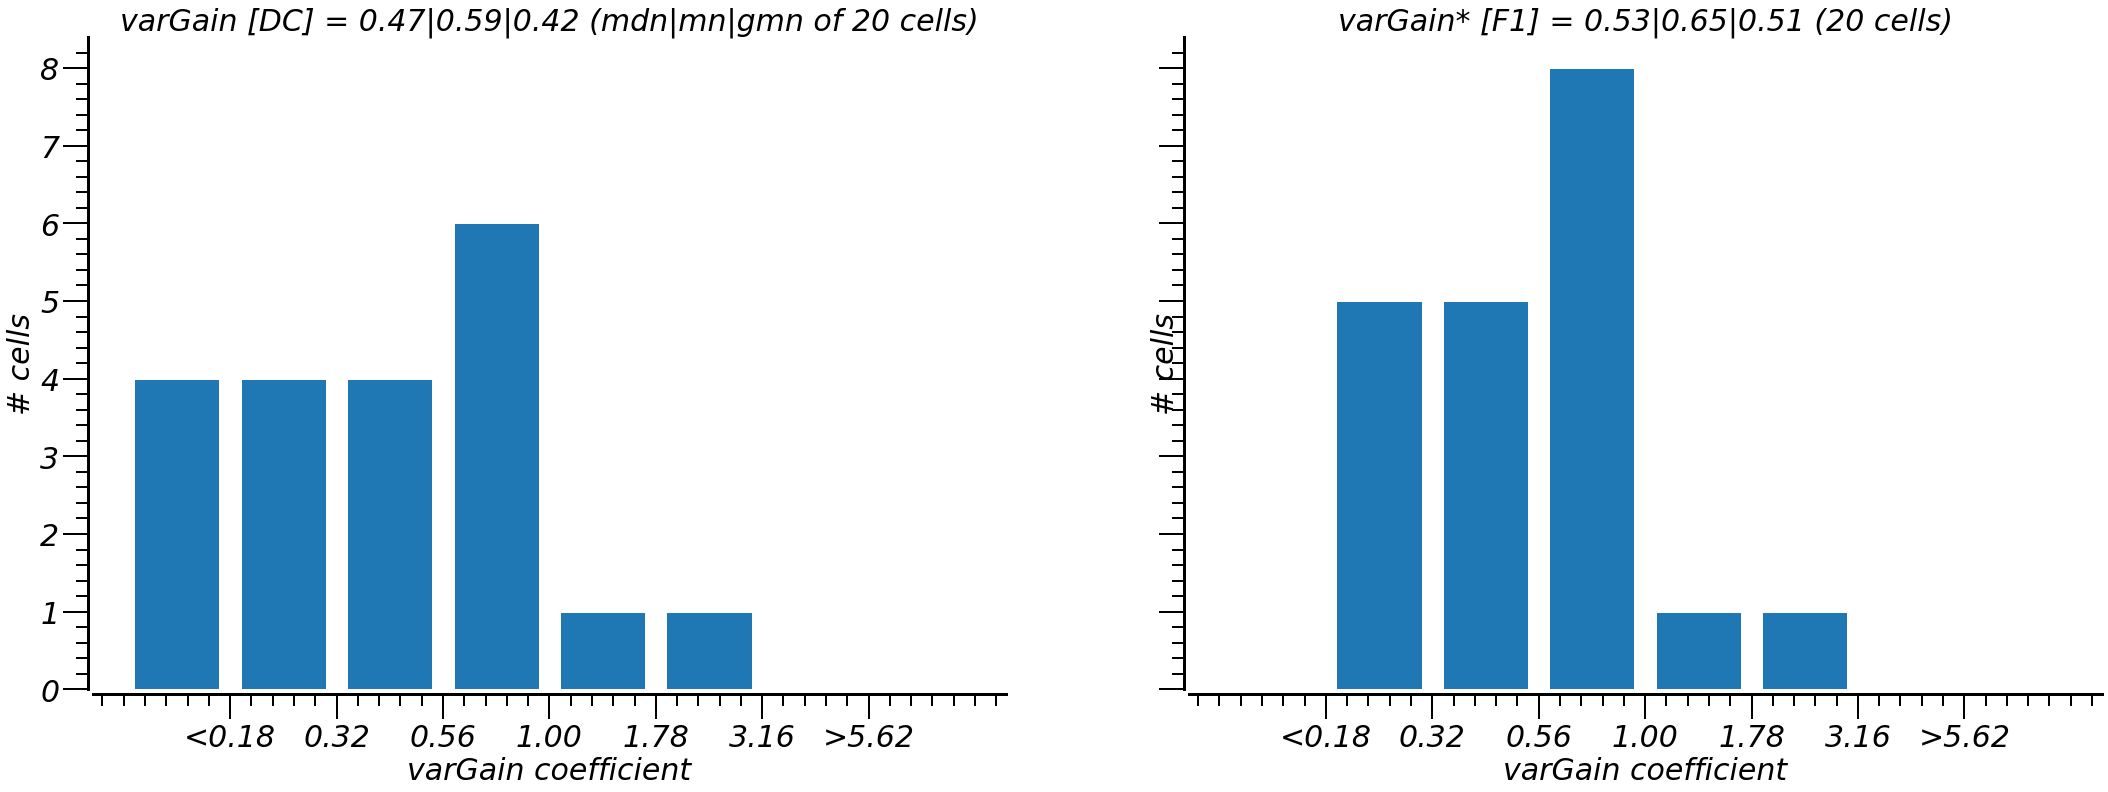

In [530]:
# Now, distribution of varGains for all cells
labels = ['DC', 'F1']

nrow,ncol=1,2
f, ax = plt.subplots(nrow,ncol,figsize=(18*ncol, 12*nrow), sharey=True)

for measure,lbl in enumerate(labels):

    # in log10 units
    bins = np.linspace(-1, 1, 9);
    stepSize = (bins[-1] - bins[0])/(len(bins)-1);
    binPlotLocs = bins[1:] - 0.5*stepSize;
    clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;
    vg_clipped = np.clip(np.log10(all_varGain[:,measure]), clipLow, clipHigh);
    tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)
    
    # calculate
    nCells = len(vg_clipped);
    medianVG = np.nanmedian(all_varGain[:,measure]);
    mnVG = np.nanmean(all_varGain[:,measure]);
    gmnVG = gmean(all_varGain[:,measure])

    # plot
    vals, _ = np.histogram(vg_clipped, bins=bins)
    vals_norm = vals/np.sum(vals)
    ax[measure].bar(binPlotLocs, vals, width=0.8*stepSize, align='center');
    tickStrs = ['%.2f' % np.power(10, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    ax[measure].set_xticks(tickVals);
    ax[measure].set_xlabel('varGain coefficient')
    ax[measure].set_ylabel('# cells')
    ax[measure].set_xticklabels(tickStrs, rotation=45);
    if measure == 0:
        ax[measure].set_title('varGain [%s] = %.2f|%.2f|%.2f (mdn|mn|gmn of %d cells)' % (lbl, medianVG, mnVG, gmnVG, nCells))
    else:
        ax[measure].set_title('varGain* [%s] = %.2f|%.2f|%.2f (%d cells)' % (lbl, medianVG, mnVG, gmnVG, nCells))
    
    sns.despine(ax=ax[measure], offset=5)
    
# now save
saveName = "/varGain_coefs.pdf" % (cellNum)
full_save = os.path.dirname(str(save_loc));
if not os.path.exists(full_save):
    os.makedirs(full_save);
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f)
pdfSv.close()

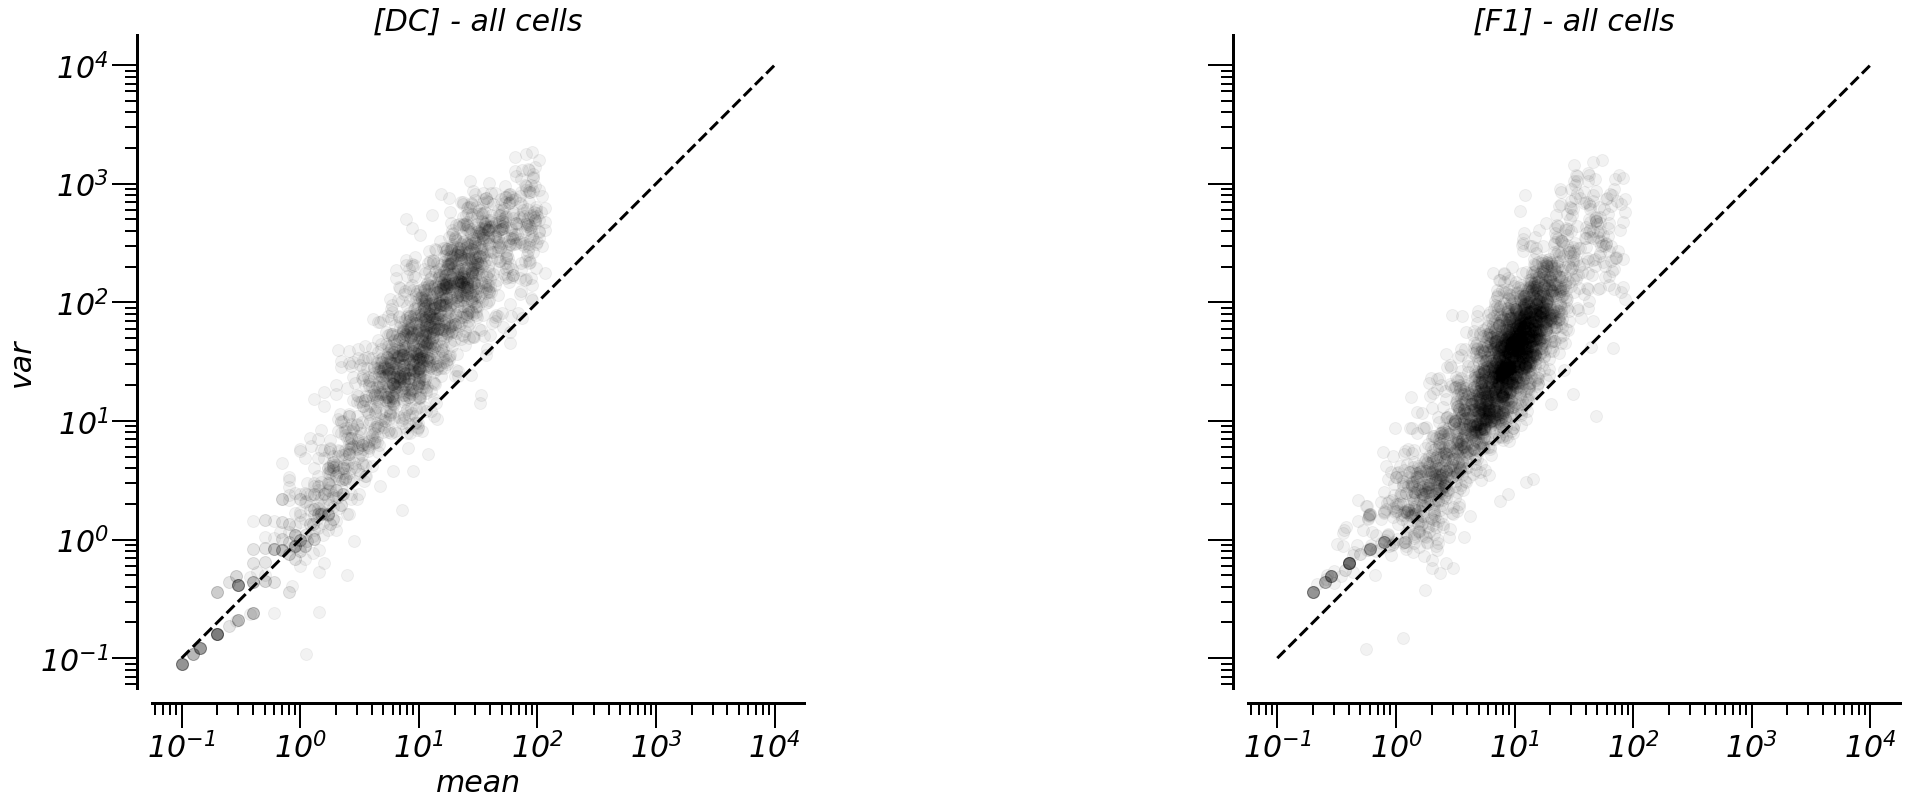

In [531]:
# And plot of ALL conditions across ALL cells
nCells = len(dataList['unitName'])

nrow,ncol=1,2
f, ax = plt.subplots(nrow,ncol,figsize=(18*ncol, 12*nrow), sharey=True)

all_mn = [all_all_mean_dc, all_all_mean_f1]
all_vr = [all_all_var_dc, all_all_var_f1]

for (measure,lbl),mn,vr in zip(enumerate(labels), all_mn, all_vr):
       
    ax[measure].scatter(mn, vr, color='k', alpha=0.05)      
            
    # labeling, etc
    ax[measure].loglog([1e-1, 1e4], [1e-1, 1e4], 'k--', label='ref.')
    ax[measure].axis('square')
    if measure == 0:
        ax[measure].set_xlabel('mean')
        ax[measure].set_ylabel('var')
    sns.despine(offset=15, ax=ax[measure])
    ax[measure].set_title('[%s] - all cells' % lbl)

# now save
saveName = "/varGain_conds.pdf" % (cellNum)
full_save = os.path.dirname(str(save_loc));
if not os.path.exists(full_save):
    os.makedirs(full_save);
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f)
pdfSv.close()

## Core experiment (Bauman+Bonds) -- plotting

### Plot single grating RVCs and SF tuning curves

In [507]:
np.array_equal(all_all_mean_dc, all_all_mean_f1)

False

In [508]:
np.array_equal(all_all_var_dc, all_all_var_f1)

False

In [512]:
# And plot of ALL conditions across ALL cells
nCells = len(dataList['unitName'])


all_mn = [all_all_mean_dc, all_all_mean_f1]
all_vr = [all_all_var_dc, all_all_var_f1]

plt.scatter(all_all_mean_dc - all_all_mean_f1, all_all_var_dc - all_all_var_f1)


ValueError: operands could not be broadcast together with shapes (1980,) (2128,) 

In [ ]:
for cellNum in np.arange(1, len(dataList['unitName'])+1):
    expName = 'sfBB_core';

    unitNm = dataList['unitName'][cellNum-1];
    cell = hf.np_smart_load('%s%s_sfBB.npy' % (path, unitNm));
    expInfo = cell[expName]
    byTrial = expInfo['trial'];

    respMatrixDC, respMatrixF1 = hf_sf.get_mask_resp(expInfo, withBase=0);
    maskSf, maskCon = expInfo['maskSF'], expInfo['maskCon'];
    f1f0_rat = hf_sf.compute_f1f0(expInfo)[0];
    ### Now, plot
    nrow, ncol = 3, 2;
    f, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*15, nrow*15))

    f.suptitle('V1 #%d [%s, f1f0: %.2f]' % (cellNum, unitNm, f1f0_rat));
    # assumes no baseline subtraction...
    maxResp = np.maximum(np.max(respMatrixDC[:,:,0]), np.max(respMatrixF1[:,:,0]))
    yLims = [0, 1.1*maxResp];
    
    for measure in [0,1]:
        if measure == 0:
            baseline = expInfo['blank']['mean'];
            data = respMatrixDC
            if baselineSub:
                data -= baseline;
            lbl = 'DC'
        elif measure == 1:
            data = respMatrixF1
            lbl = 'F1'

        # joint tuning
        ax[0, measure].contourf(maskSf, maskCon, data[:,:,0])
        ax[0, measure].set_xlabel('Spatial frequency (c/deg)');
        if measure == 0:
            ax[0, measure].set_ylabel('Contrast (%)');
        ax[0, measure].set_xscale('log');
        ax[0, measure].set_yscale('log');
        ax[0, measure].set_title('Joint tuning (%s)' % lbl)
    #     ax[measure,0].set_colorbar();

        # SF tuning with contrast
        lines = [];
        nCons = len(maskCon);
        for mcI, mC in enumerate(maskCon):
            col = [(nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons)];

            curr_line = ax[1, measure].errorbar(maskSf, data[mcI,:,0], data[mcI,:,1], marker='o', 
                                                color=col, label=str(np.round(mC, 2)) + '%')
            ax[1, measure].set_xscale('log');
            ax[1, measure].set_xlabel('SF (c/deg)')
            ax[1, measure].set_ylim(yLims);
            if measure == 0:
                ax[1, measure].set_ylabel('Response (spks/s) [%s]' % lbl)
            lines.append(curr_line);

        if measure == 0:
            ax[1, measure].axhline(baseline, color='r', linestyle='--', label='blank');
        ax[1, measure].legend(fontsize='x-small');

        # RVC across SF
        lines = [];
        nSfs = len(maskSf);
        for msI, mS in enumerate(maskSf):
            col = [(nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs)];

            curr_line = ax[2, measure].errorbar(maskCon, data[:,msI,0], data[:,msI,1], marker='o', 
                                                color=col, label=str(np.round(mS, 2)) + ' cpd')
            ax[2, measure].set_xscale('log');
            ax[2, measure].set_xlabel('Contrast (%)')
            ax[2, measure].set_ylim(yLims);
            if measure == 0:
                ax[2, measure].set_ylabel('Response (spks/s) [%s]' % lbl)
            lines.append(curr_line);

        if measure == 0:
            ax[2, measure].axhline(baseline, color='r', linestyle='--', label='blank');
        ax[2, measure].legend(fontsize='x-small');

    sns.despine(offset=10)
    f.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    saveName = "/cell_%03d_.pdf" % (cellNum)
    full_save = os.path.dirname(str(save_loc + 'summary%s/core/' % ylim_flag));
    if not os.path.exists(full_save):
        os.makedirs(full_save);
    pdfSv = pltSave.PdfPages(full_save + saveName);
    pdfSv.savefig(f)
    plt.close(f)
    pdfSv.close()


In [513]:
49*20

980

### Interlude: Tuning distrubitions, maximum responses

In [ ]:
### This will take ~3 minutes
nCells = len(dataList['unitName']);
prefSf_data = np.zeros((nCells, 2));
prefSf_mod = np.zeros((nCells, 2));
maxResp = np.zeros((nCells, 2));

for cellNum in np.arange(1, nCells+1):
    expName = 'sfBB_core';

    unitNm = dataList['unitName'][cellNum-1];
    cell = hf.np_smart_load('%s%s_sfBB.npy' % (path, unitNm));
    expInfo = cell[expName]
    byTrial = expInfo['trial'];

    respMatrixDC, respMatrixF1 = hf_sf.get_mask_resp(expInfo, withBase=0);
    maskSf, maskCon = expInfo['maskSF'], expInfo['maskCon'];
    
    sfHighCon = [respMatrixDC[-1,:,0], respMatrixF1[-1,:,0]]
    prefSf_data[cellNum-1, :] = [maskSf[np.argmax(x)] for x in sfHighCon]
    prefSf_mod[cellNum-1, :] = [hf.tfTune(maskSf, x, tfResps_std=None, baselineSub=False, nOpts = 30)[0] for x in sfHighCon]
    maxResp[cellNum-1, :] = [np.max(x) for x in sfHighCon];

In [ ]:
### Plot prefSf distr, then maxResp distr

## now setup plot
nrow, ncol = 2, 2;
f, ax = plt.subplots(nrow, ncol, figsize=(ncol*15, nrow*12), sharey=True)

## SF
bins = np.linspace(-2.5, 3.5, 9); # in log space
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

psfs = [prefSf_mod[:,0], prefSf_mod[:,1]];
fitStr = ['DC', 'F1']

psfs_clipped = [np.clip(hf.nan_rm(np.log2(x)), clipLow, clipHigh) for x in psfs];
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)
# tickVals = np.linspace(bins[1]+0.5*stepSize, bins[-2]+0.5*stepSize, 10)

# calculate
nSF = [len(x) for x in psfs_clipped]
medianSF = [np.nanmedian(x) for x in psfs];
mnSF = [np.nanmean(x) for x in psfs];
gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];
ylim = [0, 0.35]

for i in range(2):

    plt.subplot(nrow,ncol,1+i)
    vals, _ = np.histogram(psfs_clipped[i], bins=bins)
    vals_norm = vals/np.sum(vals)
    plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
    sns.despine(offset=10)
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);

    plt.ylim(ylim);
    plt.xlabel('spatial frequency (c/deg)');
    plt.title('Distr. of freq pref [%s] (V1, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], nSF[i], medianSF[i], mnSF[i], gmnSF[i]));

## Max resp
bins = np.linspace(0, 120, 9); # in linear space
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;

clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

maxResps = [maxResp[:,0], maxResp[:,1]];
maxResps_clipped = [np.clip(hf.nan_rm(x), clipLow, clipHigh) for x in maxResps];
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

# calculate
nMR = [len(x) for x in maxResps_clipped]
medianMR = [np.nanmedian(x) for x in maxResps];
mnMR = [np.nanmean(x) for x in maxResps];
ylim = [0, 0.5]

for i in range(2):

    plt.subplot(nrow,ncol, ncol+1+i)
    vals, _ = np.histogram(maxResps_clipped[i], bins=bins)
    vals_norm = vals/np.sum(vals)
    plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
    sns.despine(offset=10)

    plt.xlabel('Response (spks/s)');
    plt.title('Distribution of maximum response [%s] (V1, n=%d, median=%.2f, mn=%.2f)' % (fitStr[i], nMR[i], medianMR[i], mnMR[i]));
    plt.ylim(ylim);
    
# now save
saveName = "/sf_maxResp_sfBB.pdf" % (cellNum)
full_save = os.path.dirname(str(save_loc + 'pop_distr/'));
if not os.path.exists(full_save):
    os.makedirs(full_save);
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f)
pdfSv.close()

### Plot the influence of the mask on base response

In [498]:
all_all_mean_dc

[]

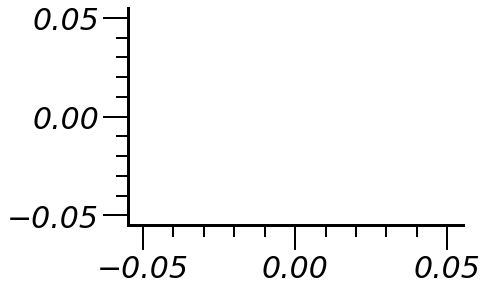

In [497]:
plt.plot(all_all_mean_dc, 'o')

In [231]:
import model_responses_pytorch as mrpt

In [232]:
autoreload.reload(mrpt)
autoreload.reload(hf)
autoreload.reload(hf_sf)

<module 'helper_fcns_sfBB' from '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns_sfBB.py'>

In [235]:
# modFits = hf.np_smart_load('V1_BB/structures/fitList_pyt_200507_LGN_flat_poiss.npy')
modFits = hf.np_smart_load('V1_BB/structures/fitList_pyt_200507_wght_sqrt.npy')
cellNum = 1;
currFits = modFits[cellNum-1];

datalist = hf.np_smart_load('V1_BB/structures/dataList.npy');
curr_cell = hf.np_smart_load('V1_BB/structures/%s_sfBB.npy' % datalist['unitName'][cellNum-1])

In [236]:
coreExp = curr_cell['sfBB_core'];
newMethod = 1;
excType = 2;
lossType = 2;
normType = 2;
lgnFrontEnd = 1;

# first DC
respMeasure = 0; # 0 for DC; 1 for F1
prms = currFits['dc']['params'];
curr_mod = mrpt.sfNormMod(modParams=prms, excType=excType, expInd=-1, normType=normType, 
                          lgnFrontEnd=lgnFrontEnd, lossType=lossType, newMethod=newMethod)
trInf_dc, resp_dc = mrpt.process_data(coreExp, expInd=-1, respMeasure=respMeasure)
mod_resps_dc = curr_mod.forward(trInf_dc, respMeasure=respMeasure).detach().numpy();
    
# then F1
respMeasure = 1; # 0 for DC; 1 for F1
prms = currFits['f1']['params'];
curr_mod = mrpt.sfNormMod(modParams=prms, excType=excType, expInd=-1, normType=normType, 
                          lgnFrontEnd=lgnFrontEnd, lossType=lossType, newMethod=newMethod)
trInf_f1, resp_f1 = mrpt.process_data(coreExp, expInd=-1, respMeasure=respMeasure)
mod_resps_f1 = curr_mod.forward(trInf_f1, respMeasure=respMeasure).detach().numpy();

coreMod = coreExp.copy()
coreMod['spikeCounts'] = mod_resps_dc;
coreMod['f1_base'] = mod_resps_f1[:,0];
coreMod['f1_mask'] = mod_resps_f1[:,1];

KeyError: 'params'

Text(0.5, 1.0, 'F1::mask')

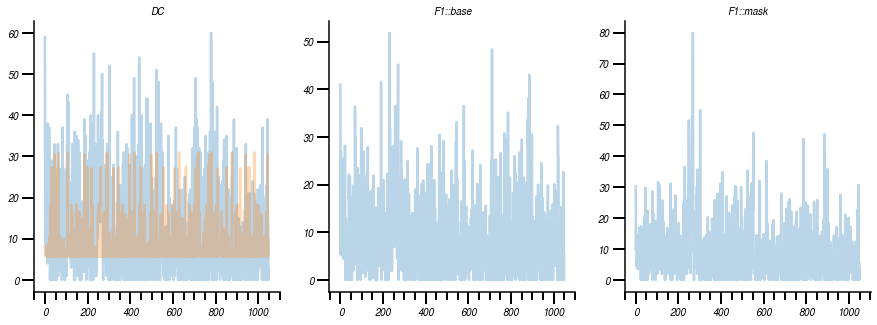

In [211]:
ncol=3; nrow=1
f, ax = plt.subplots(nrow, ncol, figsize=(5*ncol, 5*nrow))

valTrials = trInf['num']

ax[0].plot(coreExp['spikeCounts'][valTrials], alpha=0.3);
ax[0].plot(coreMod['spikeCounts'], alpha=0.3)
ax[0].set_title('DC')

ax[1].plot(coreExp['f1_base'][valTrials], alpha=0.3);
ax[1].plot(coreMod['f1_base'], alpha=0.3)
ax[1].set_title('F1::base')

ax[2].plot(coreExp['f1_mask'][valTrials], alpha=0.3);
ax[2].plot(coreMod['f1_mask'], alpha=0.3)
ax[2].set_title('F1::mask')


In [212]:
import torch

In [213]:
[x for x in curr_mod.named_parameters()]

[('mWeight',
  Parameter containing:
  tensor(1.3268, requires_grad=True)),
 ('prefSf',
  Parameter containing:
  tensor(1.3571, requires_grad=True)),
 ('sigLow',
  Parameter containing:
  tensor(1.3235, requires_grad=True)),
 ('sigHigh',
  Parameter containing:
  tensor(2.6384, requires_grad=True)),
 ('sigma',
  Parameter containing:
  tensor(-1.9601, requires_grad=True)),
 ('respExp',
  Parameter containing:
  tensor(3.0682, requires_grad=True)),
 ('scale',
  Parameter containing:
  tensor(0.7748, requires_grad=True)),
 ('noiseEarly',
  Parameter containing:
  tensor(-0.0289, requires_grad=True)),
 ('noiseLate',
  Parameter containing:
  tensor(0.0434, requires_grad=True)),
 ('gs_mean',
  Parameter containing:
  tensor(-0.0864, requires_grad=True)),
 ('gs_std',
  Parameter containing:
  tensor(2.6384, requires_grad=True))]

In [229]:
sfs = mrpt._cast_as_tensor(np.geomspace(0.3, 10, 100));
log_sfs = torch.log(sfs);
gs_mean = mrpt._cast_as_tensor(curr_mod.gs_mean);
gs_std = mrpt._cast_as_tensor(curr_mod.gs_std);
weight_distr = torch.distributions.normal.Normal(gs_mean, gs_std)
new_weights = torch.exp(weight_distr.log_prob(log_sfs));

lgnStage = torch.ones_like(sfs);
new_weights = torch.mul(lgnStage, new_weights);


/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/model_responses_pytorch.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)


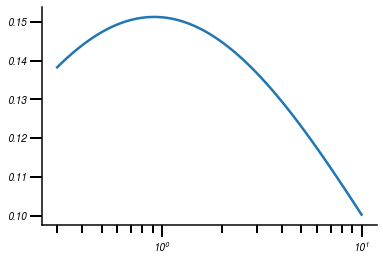

In [230]:
plt.semilogx(sfs, new_weights)

In [180]:
coreMod.keys()

dict_keys(['trial', 'spikeTimes', 'spikeCounts', 'f1_mask', 'f1_base', 'blank', 'base', 'maskSF', 'baseSF', 'maskCon', 'baseCon'])

#### Updated method: Show mask+base response in addition to mask alone (rather than jumping straight to R(mask+base) - R(base)

In [52]:
for cellNum in np.arange(1, len(dataList['unitName'])+1):
    expName = 'sfBB_core';

    unitNm = dataList['unitName'][cellNum-1];
    cell = hf.np_smart_load('%s%s_sfBB.npy' % (path, unitNm));
    expInfo = cell[expName]
    byTrial = expInfo['trial'];
    f1f0_rat = hf_sf.compute_f1f0(expInfo)[0];

    ### Get the responses - base only, mask+base [base F1], mask only (mask F1)
    baseDistrs, _, baseConds = hf_sf.get_baseOnly_resp(expInfo);
    # - unpack DC, F1 distribution of responses per trial
    baseDC, baseF1 = baseDistrs;
    baseDC_mn, baseF1_mn = np.mean(baseDC), np.mean(baseF1);
    # - unpack the SF x CON of the base (guaranteed to have only one set for sfBB_core)
    baseSf_curr, baseCon_curr = baseConds[0];
    # now get the mask+base response (f1 at base TF)
    respMatrixDC, respMatrixF1 = hf_sf.get_mask_resp(expInfo, withBase=1, maskF1=0); # i.e. get the base response for F1
    # and get the mask only response (f1 at mask TF)
    respMatrixDC_onlyMask, respMatrixF1_onlyMask = hf_sf.get_mask_resp(expInfo, withBase=0, maskF1=1); # i.e. get the maskONLY response
    # and get the mask+base response (but f1 at mask TF)
    _, respMatrixF1_maskTf = hf_sf.get_mask_resp(expInfo, withBase=1, maskF1=1); # i.e. get the maskONLY response

    ## Reference tuning...
    refDC, refF1 = hf_sf.get_mask_resp(expInfo, withBase=0); # i.e. mask only, at mask TF
    maskSf, maskCon = expInfo['maskSF'], expInfo['maskCon'];
    # - get DC tuning curves
    refDC_sf = refDC[-1, :, :]; # highest contrast
    prefSf_ind = np.argmax(refDC_sf[:, 0]);
    prefSf_DC = maskSf[prefSf_ind];
    refDC_rvc = refDC[:, prefSf_ind, :];
    # - get F1 tuning curves
    refF1_sf = refF1[-1, :, :];
    prefSf_ind = np.argmax(refF1_sf[:, 0]);
    prefSf_F1 = maskSf[prefSf_ind];
    refF1_rvc = refF1[:, prefSf_ind, :];
    
    ### Now, plot
    nrow, ncol = 5, 4;
    f, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*15, nrow*15))

    f.suptitle('V1 #%d [%s, f1f0: %.2f] base: %.2f cpd, %.2f%%' % (cellNum, unitNm, f1f0_rat, baseSf_curr, baseCon_curr),
              fontsize='x-large');
    
    maxResp = np.maximum(np.max(respMatrixDC), np.max(respMatrixF1));
    maxResp_onlyMask = np.maximum(np.max(respMatrixDC_onlyMask), np.max(respMatrixF1_onlyMask));
    maxResp_total = np.maximum(maxResp, maxResp_onlyMask);
    overall_ylim = [0, 1.2*maxResp_total];
    # also get the bounds for the AbLe plot - only DC
    AbLe_mn = np.nanmin(respMatrixDC[:,:,0]-baseDC_mn-respMatrixDC_onlyMask[:,:,0])
    AbLe_mx = np.nanmax(respMatrixDC[:,:,0]-baseDC_mn-respMatrixDC_onlyMask[:,:,0])
    AbLe_bounds = [np.sign(AbLe_mn)*1.2*np.abs(AbLe_mn), np.maximum(5, 1.2*AbLe_mx)]; # ensure we go at least above 0 with the max
    
    ######
    for measure in [0,1]:
        if measure == 0:
            baseline = expInfo['blank']['mean'];
            data = respMatrixDC;
            data_baseTF = None;
            maskOnly = respMatrixDC_onlyMask;
            baseOnly = baseDC
            refAll = refDC[:,:,0];
            refSf = refDC_sf;
            refRVC = refDC_rvc;
            refSf_pref = prefSf_DC;
            if baselineSub:
                data -= baseline
                baseOnly -= baseline;
            xlim_base = overall_ylim;
            ylim_diffsAbLe = AbLe_bounds;
            lbl = 'DC'
        elif measure == 1:
            data = respMatrixF1_maskTf;
            data_baseTf = respMatrixF1;
            maskOnly = respMatrixF1_onlyMask;
            baseOnly = baseF1;
            refAll = refF1[:,:,0];
            refSf = refF1_sf;
            refRVC = refF1_rvc;
            refSf_pref = prefSf_F1;
            xlim_base = overall_ylim
            lbl = 'F1'

        # Now, subtract the baseOnly response from the base+mask response (base frequency for F1)
        # -- but store it separately 
        data_sub = np.copy(data);
        data_sub[:,:,0] = data[:,:,0]-np.mean(baseOnly);

        ### first, just the distribution of base responses
        ax[0, measure] = plt.subplot(nrow, 2, 1+measure); # pretend there are only 2 columns

        sns.distplot(baseOnly, ax=ax[0, measure], kde=False);
        base_mn, base_sem = np.mean(baseOnly), np.std(baseOnly)/len(baseOnly);

        ax[0, measure].set_xlim(xlim_base)
        ax[0, measure].set_title('[%s] mn|sem = %.2f|%.2f' % (lbl, base_mn, base_sem))
        if measure == 0:
            ax[0, measure].axvline(baseline, linestyle='--', color='r')

        # SF tuning with contrast
        resps = [maskOnly, data, data_baseTf]; #need to plot data_baseTf for f1
        labels = ['mask', 'mask+base', 'mask+base']
        measure_lbl = np.vstack((['', '', ''], ['', ' (mask TF)', ' (base TF)'])); # specify which TF, if F1 response
        labels_ref = ['blank', 'base']
        floors = [baseline, base_mn]; # i.e. the blank response, then the response to the base alone
        
        for ii, rsps in enumerate(resps): # first mask only, then mask+base (data)
            nCons = len(maskCon);
            # we don't plot the F1 at base TF for DC response...
            if measure == 0 and ii == (len(resps)-1):
                continue;

            for mcI, mC in enumerate(maskCon):

                col = [(nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons)];

                curr_line = ax[1+ii, 2*measure].errorbar(maskSf, rsps[mcI,:,0], rsps[mcI,:,1], marker='o', 
                                                    color=col, label=str(np.round(mC, 2)) + '%')
            ax[1+ii, 2*measure].set_xscale('log');
            ax[1+ii, 2*measure].set_xlabel('SF (c/deg)')
            ax[1+ii, 2*measure].set_ylabel('Response (spks/s) [%s]' % lbl)
            ax[1+ii, 2*measure].set_title(labels[ii] + measure_lbl[measure, ii]);
            ax[1+ii, 2*measure].set_ylim(overall_ylim);
            if measure == 0: # only do the blank response reference for DC
                ax[1+ii, 2*measure].axhline(floors[0], linestyle='--', color='r', label=labels_ref[0])
            # i.e. always put the baseOnly reference line...
            ax[1+ii, 2*measure].axhline(floors[1], linestyle='--', color='b', label=labels_ref[1])
            ax[1+ii, 2*measure].legend(fontsize='small');

        # RVC across SF
        for ii, rsps in enumerate(resps): # first mask only, then mask+base (data)
            nSfs = len(maskSf);

            # we don't plot the F1 at base TF for DC response...
            if measure == 0 and ii == (len(resps)-1):
                continue;

            for msI, mS in enumerate(maskSf):
                
                col = [(nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs)];

                curr_line = ax[1+ii, 1+2*measure].errorbar(maskCon, rsps[:,msI,0], rsps[:,msI,1], marker='o', 
                                                    color=col, label=str(np.round(mS, 2)) + ' cpd')
            ax[1+ii, 1+2*measure].set_xscale('log');
            ax[1+ii, 1+2*measure].set_xlabel('Contrast (%)')
            ax[1+ii, 1+2*measure].set_ylabel('Response (spks/s) [%s]' % lbl)
            ax[1+ii, 1+2*measure].set_title(labels[ii] + measure_lbl[measure, ii])
            ax[1+ii, 1+2*measure].set_ylim(overall_ylim);
            if measure == 0: # only do the blank response for DC
                ax[1+ii, 1+2*measure].axhline(floors[0], linestyle='--', color='r', label=labels_ref[0])
            # i.e. always put the baseOnly reference line...
            ax[1+ii, 1+2*measure].axhline(floors[1], linestyle='--', color='b', label=labels_ref[1])
            ax[1+ii, 1+2*measure].legend(fontsize='small');

        ### joint tuning (mask only)
        ax[4, measure] = plt.subplot(nrow, 2, 2*nrow-1+measure); # pretend there are only 2 columns

        ax[4, measure].contourf(maskSf, maskCon, refAll)
        ax[4, measure].set_xlabel('Spatial frequency (c/deg)');
        ax[4, measure].set_ylabel('Contrast (%)');
        ax[4, measure].set_xscale('log');
        ax[4, measure].set_yscale('log');
        ax[4, measure].set_title('Joint REF tuning (%s)' % lbl)

        ### SF tuning with contrast [rows 1-4, column 1 (& 3)]
#         lines = []; linesNorm = []; linesAbLe = [];
        nCons = len(maskCon);
        for mcI, mC in enumerate(maskCon):
            col = [(nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons)];

            if measure == 0:
                curr_line = ax[3, 2*measure].errorbar(maskSf, data_sub[mcI,:,0]-maskOnly[mcI,:,0], data_sub[mcI,:,1],
                                                      marker='o', color=col, label=str(np.round(mC, 2)) + '%')
#                 linesAbLe.append(curr_line);
                ax[3, 2*measure].set_ylim(ylim_diffsAbLe)
#             else:
#                 ax[3, 2*measure].axis('off'); # cannot do Abramov-Levine with F1!
                 
        ylim_diffs = [ylim_diffsAbLe];
        diff_endings = [' - R(m))'];
        for (j,ylim),txt in zip(enumerate(ylim_diffs), diff_endings):
            ax[3+j, 2*measure].set_xscale('log');
            ax[3+j, 2*measure].set_xlabel('SF (c/deg)')
            ax[3+j, 2*measure].set_ylabel('Difference (R(m+b) - R(b)%s (spks/s) [%s]' % (txt,lbl))
            if measure==1: # Abramov/Levine sub. -- only DC has this analysis
                pass;
            else:
                ax[3+j, 2*measure].axhline(0, color='k', linestyle='--')
            ax[3+j, 2*measure].legend(fontsize='small');

        ### RVC across SF [rows 1-4, column 2 (& 4)]
        lines = []; linesNorm = []; linesAbLe = [];
        nSfs = len(maskSf);
        for msI, mS in enumerate(maskSf):
            col = [(nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs)];

            if measure == 0:
                curr_line = ax[3, 1+2*measure].errorbar(maskCon, data_sub[:,msI,0] - maskOnly[:,msI,0], data_sub[:,msI,1],
                                                        marker='o', color=col, label=str(np.round(mS, 2)) + ' cpd')
                linesAbLe.append(curr_line);
                ax[3, 1+2*measure].set_ylim(ylim_diffsAbLe)

        for (j,ylim),txt in zip(enumerate(ylim_diffs), diff_endings):
            ax[3+j, 1+2*measure].set_xscale('log');
            ax[3+j, 1+2*measure].set_xlabel('Contrast (%%)')
#             ax[3+j, 1+2*measure].set_ylabel('Difference (R(m+b) - R(b)%s (spks/s) [%s]' % (txt, lbl))
            if measure==1: # Abramov/Levine sub. -- only DC has this analysis
                pass;
            else:
                ax[3+j, 1+2*measure].axhline(0, color='k', linestyle='--')
            ax[3+j, 1+2*measure].legend(fontsize='small');

    sns.despine(offset=10)
    f.tight_layout(rect=[0, 0.03, 1, 0.95])

    saveName = "/cell_%03d_both.pdf" % (cellNum)
    full_save = os.path.dirname(str(save_loc + 'summary/core/both/'));
    if not os.path.exists(full_save):
        os.makedirs(full_save);
    pdfSv = pltSave.PdfPages(full_save + saveName);
    pdfSv.savefig(f)
    plt.close(f)
    pdfSv.close()


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

#### Original method (separate plot for influence of mask)

In [ ]:
expDir = 'V1_BB/';
path = '%sstructures/' % expDir;
dataList = hf.np_smart_load(path + 'dataList.npy')

save_loc = '%sfigures/' % expDir;

baselineSub = 0;
fix_ylim = 0;

if fix_ylim == 1:
    ylim_flag = '';
else:
    ylim_flag = '_free'

In [ ]:
for cellNum in np.arange(1, len(dataList['unitName'])+1):
    expName = 'sfBB_core';

    unitNm = dataList['unitName'][cellNum-1];
    cell = hf.np_smart_load('%s%s_sfBB.npy' % (path, unitNm));
    expInfo = cell[expName]
    byTrial = expInfo['trial'];

    f1f0_rat = hf_sf.compute_f1f0(expInfo)[0];
    ### Get the responses - base only, mask+base [base F1], mask only (mask F1)
    baseDistrs, _, baseConds = hf_sf.get_baseOnly_resp(expInfo);
    # - unpack DC, F1 distribution of responses per trial
    baseDC, baseF1 = baseDistrs;
    # - unpack the SF x CON of the base (guaranteed to have only one set for sfBB_core)
    baseSf_curr, baseCon_curr = baseConds[0];
    # now get the mask+base response (f1 at base TF)
    respMatrixDC, respMatrixF1 = hf_sf.get_mask_resp(expInfo, withBase=1, maskF1=0); # i.e. get the base response for F1
    # and get the mask only response (f1 at mask TF);
    respMatrixDC_onlyMask, respMatrixF1_onlyMask = hf_sf.get_mask_resp(expInfo, withBase=0, maskF1=1); # i.e. get the maskONLY response

    ## Reference tuning...
    refDC, refF1 = hf_sf.get_mask_resp(expInfo, withBase=0); # i.e. mask only, at mask TF
    maskSf, maskCon = expInfo['maskSF'], expInfo['maskCon'];
    # - get DC tuning curves
    refDC_sf = refDC[-1, :, :]; # highest contrast
    prefSf_ind = np.argmax(refDC_sf[:, 0]);
    prefSf_DC = maskSf[prefSf_ind];
    refDC_rvc = refDC[:, prefSf_ind, :];
    # - get F1 tuning curves
    refF1_sf = refF1[-1, :, :];
    prefSf_ind = np.argmax(refF1_sf[:, 0]);
    prefSf_F1 = maskSf[prefSf_ind];
    refF1_rvc = refF1[:, prefSf_ind, :];
    
    ### Now, plot
    nrow, ncol = 5+fix_ylim, 4;
    f, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*15, nrow*15))

    f.suptitle('V1 #%d [%s, f1f0: %.2f] base: %.2f cpd, %.2f%%' % (cellNum, unitNm, f1f0_rat, baseSf_curr, baseCon_curr));
    
    maxResp = np.maximum(np.max(respMatrixDC), np.max(respMatrixF1));
    maxResp_onlyMask = np.maximum(np.max(respMatrixDC_onlyMask), np.max(respMatrixF1_onlyMask));
    maxResp_total = np.maximum(maxResp, maxResp_onlyMask);
    overall_ylim = [0, 1.2*maxResp_total];
    # get the bounds for the difference plot (R(m+b) - R(b))
    dc_min = np.nanmin(respMatrixDC[:,:,0]-np.mean(baseDC))
    dc_max = np.nanmax(respMatrixDC[:,:,0]-np.mean(baseDC))
    f1_min = np.nanmin(respMatrixDC[:,:,0]-np.mean(baseF1))
    f1_max = np.nanmax(respMatrixDC[:,:,0]-np.mean(baseF1))
    diff_min = np.minimum(dc_min, f1_min);
    diff_max = np.maximum(dc_max, f1_max);
    diff_bounds = [np.sign(diff_min)*1.2*np.abs(diff_min), np.maximum(5, 1.2*diff_max)]; # ensure we go at least above 0 with the max
    # also get the bounds for the AbLe plot - only DC
    AbLe_mn = np.nanmin(respMatrixDC[:,:,0]-np.mean(baseDC)-respMatrixDC_onlyMask[:,:,0])
    AbLe_mx = np.nanmax(respMatrixDC[:,:,0]-np.mean(baseDC)-respMatrixDC_onlyMask[:,:,0])
    AbLe_bounds = [np.sign(AbLe_mn)*1.2*np.abs(AbLe_mn), np.maximum(5, 1.2*AbLe_mx)]; # ensure we go at least above 0 with the max

    ######
    for measure in [0,1]:
        if measure == 0:
            baseline = expInfo['blank']['mean'];
            data = respMatrixDC;
            data_baseTf = None;
            maskOnly = respMatrixDC_onlyMask;
            baseOnly = baseDC
            refAll = refDC[:,:,0];
            refSf = refDC_sf;
            refRVC = refDC_rvc;
            refSf_pref = prefSf_DC;
            if baselineSub:
                data -= baseline
                baseOnly -= baseline;
            xlim_base = [-5, 120]
            if fix_ylim == 1:
                ylim_diffs = [-50, 60]
                ylim_diffNorm = [-1.5, 1.5];
                ylim_diffsAbLe = [-100, 20]
            else:
                ylim_diffs = diff_bounds;
                ylim_diffsAbLe = AbLe_bounds;
            lbl = 'DC'
        elif measure == 1:
            data = respMatrixF1_maskTf;
            data_baseTf = respMatrixF1;
            maskOnly = respMatrixF1_onlyMask;
            baseOnly = baseF1;
            refAll = refF1[:,:,0];
            refSf = refF1_sf;
            refRVC = refF1_rvc;
            refSf_pref = prefSf_F1;
            xlim_base = [-5, 120]
            if fix_ylim == 1:
                ylim_diffs = [-40, 40]
                ylim_diffNorm = [-1.5, 1.5];
            else:
                ylim_diffs = diff_bounds;
            lbl = 'F1'

        # Now, subtract the baseOnly response from the base+mask response (base frequency for F1)
        data[:,:,0] = data[:,:,0]-np.mean(baseOnly);

        ### first, just the distribution of base responses
        ax[0, measure] = plt.subplot(nrow, 2, 1+measure); # pretend there are only 2 columns

        sns.distplot(baseOnly, ax=ax[0, measure], kde=False);
        base_mn, base_sem = np.mean(baseOnly), np.std(baseOnly)/len(baseOnly);

        ax[0, measure].set_xlim(xlim_base)
        ax[0, measure].set_title('[%s] mn|sem = %.2f|%.2f' % (lbl, base_mn, base_sem))
        if measure == 0:
            ax[0, measure].axvline(baseline, linestyle='--', color='r')

        # - now, the normalized change in response
        print('base mean %.2f' % base_mn)
        dataNorm = np.divide(data[:,:,0], base_mn);

        ### basic tunings (SF, RVC)
        # SF tuning with contrast
        lines = [];
        nCons = len(maskCon);
        for mcI, mC in enumerate(maskCon):
            col = [(nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons)];
            
            curr_line = ax[1, 2*measure].errorbar(maskSf, maskOnly[mcI,:,0], maskOnly[mcI,:,1], marker='o', 
                                                color=col, label=str(np.round(mC, 2)) + '%')
            ax[1, 2*measure].set_xscale('log');
            ax[1, 2*measure].set_xlabel('SF (c/deg)')
            ax[1, 2*measure].set_ylim(overall_ylim);
            if measure == 0:
                ax[1, 2*measure].set_ylabel('Response (spks/s) [%s]' % lbl)
            lines.append(curr_line);

        if measure == 0:
            ax[1, 2*measure].axhline(baseline, color='r', linestyle='--', label='blank');
        ax[1, 2*measure].legend(fontsize='x-small');
        ax[1, 2*measure].set_title('mask only')

        # RVC across SF
        lines = [];
        nSfs = len(maskSf);
        for msI, mS in enumerate(maskSf):
            col = [(nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs)];
            
            curr_line = ax[1, 1+2*measure].errorbar(maskCon, maskOnly[:,msI,0], maskOnly[:,msI,1], marker='o', 
                                                color=col, label=str(np.round(mS, 2)) + ' cpd')
            ax[1, 1+2*measure].set_xscale('log');
            ax[1, 1+2*measure].set_xlabel('Contrast (%)')
            ax[1, 1+2*measure].set_ylim(overall_ylim);
            if measure == 0:
                ax[1, 1+2*measure].set_ylabel('Response (spks/s) [%s]' % lbl)
            lines.append(curr_line);

        if measure == 0:
            ax[1, 1+2*measure].axhline(baseline, color='r', linestyle='--', label='blank');
        ax[1, 1+2*measure].legend(fontsize='x-small');
        ax[1, 1+2*measure].set_title('mask only');

        #####################
                
        ### joint tuning
        ax[4+fix_ylim, measure] = plt.subplot(nrow, 2, 2*nrow-1+measure); # pretend there are only 2 columns

        ax[4+fix_ylim, measure].contourf(maskSf, maskCon, refAll)
        ax[4+fix_ylim, measure].set_xlabel('Spatial frequency (c/deg)');
        ax[4+fix_ylim, measure].set_ylabel('Contrast (%)');
        ax[4+fix_ylim, measure].set_xscale('log');
        ax[4+fix_ylim, measure].set_yscale('log');
        ax[4+fix_ylim, measure].set_title('Joint REF tuning (%s)' % lbl)

        ### SF tuning with contrast [rows 1-4, column 1 (& 3)]
        lines = []; linesNorm = []; linesAbLe = [];
        nCons = len(maskCon);
        for mcI, mC in enumerate(maskCon):
            col = [(nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons)];

            curr_line = ax[2, 2*measure].errorbar(maskSf, data[mcI,:,0], data[mcI,:,1], marker='o', 
                                                color=col, label=str(np.round(mC, 2)) + '%')
            lines.append(curr_line);

            if fix_ylim == 1:
                curr_line = ax[3, 2*measure].plot(maskSf, dataNorm[mcI,], marker='o', 
                                                    color=col, label=str(np.round(mC, 2)) + '%')
                linesNorm.append(curr_line);

            if measure == 0:
                curr_line = ax[3+fix_ylim, 2*measure].errorbar(maskSf, data[mcI,:,0]-maskOnly[mcI,:,0], data[mcI,:,1],
                                                      marker='o', color=col, label=str(np.round(mC, 2)) + '%')
                linesAbLe.append(curr_line);
            else:
                ax[3+fix_ylim, 2*measure].axis('off'); # cannot do Abramov-Levine with F1!
 
        if fix_ylim == 1:
            ylim_diffs = [ylim_diffs, ylim_diffNorm, ylim_diffsAbLe];
            diff_endings = [')', ') (norm)', ' - R(m))'];
        else:
            ylim_diffs = [ylim_diffs, ylim_diffsAbLe];
            diff_endings = [')', ' - R(m))'];
        for (j,ylim),txt in zip(enumerate(ylim_diffs), diff_endings):
            ax[2+j, 2*measure].set_xscale('log');
            ax[2+j, 2*measure].set_xlabel('SF (c/deg)')
            ax[2+j, 2*measure].set_ylabel('Difference (R(m+b) - R(b)%s (spks/s) [%s]' % (txt,lbl))
            ax[2+j, 2*measure].set_ylim(ylim);
                
            if j==(len(ylim_diffs)-1) and measure==1: # the last "j" is the Abramov/Levine sub. -- only DC has this analysis
                pass;
            else:
                ax[2+j, 2*measure].axhline(0, color='k', linestyle='--')
            ax[2+j, 2*measure].legend(fontsize='x-small');

        ### RVC across SF [rows 1-4, column 2 (& 4)]
        lines = []; linesNorm = []; linesAbLe = [];
        nSfs = len(maskSf);
        for msI, mS in enumerate(maskSf):
            col = [(nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs)];

            curr_line = ax[2, 1+2*measure].errorbar(maskCon, data[:,msI,0], data[:,msI,1], marker='o', 
                                                color=col, label=str(np.round(mS, 2)) + ' cpd')
            lines.append(curr_line);

            if fix_ylim == 1:
                curr_line = ax[3, 1+2*measure].plot(maskCon, dataNorm[:,msI], marker='o', 
                                                    color=col, label=str(np.round(mS, 2)) + ' cpd')
                linesNorm.append(curr_line);

            if measure == 0:
                curr_line = ax[3+fix_ylim, 1+2*measure].errorbar(maskCon, data[:,msI,0] - maskOnly[:,msI,0], data[:,msI,1],
                                                        marker='o', color=col, label=str(np.round(mS, 2)) + ' cpd')
                linesAbLe.append(curr_line);
            else:
                ax[3+fix_ylim, 1+2*measure].axis('off'); # cannot do Abramov-Levine with F1!

        for (j,ylim),txt in zip(enumerate(ylim_diffs), diff_endings):
            ax[2+j, 1+2*measure].set_xscale('log');
            ax[2+j, 1+2*measure].set_xlabel('Contrast (%%)')
            ax[2+j, 1+2*measure].set_ylabel('Difference (R(m+b) - R(b)%s (spks/s) [%s]' % (txt, lbl))
            ax[2+j, 1+2*measure].set_ylim(ylim)

            if j==(len(ylim_diffs)-1) and measure==1: # the last "j" is the Abramov/Levine sub. -- only DC has this analysis
                pass;
            else:
                ax[2+j, 1+2*measure].axhline(0, color='k', linestyle='--')
            ax[2+j, 1+2*measure].legend(fontsize='x-small');

    sns.despine(offset=10)
    f.tight_layout(rect=[0, 0.03, 1, 0.95])


    saveName = "/cell_%03d_wBase.pdf" % (cellNum)
    full_save = os.path.dirname(str(save_loc + 'summary%s/core/' % ylim_flag));
    if not os.path.exists(full_save):
        os.makedirs(full_save);
    pdfSv = pltSave.PdfPages(full_save + saveName);
    pdfSv.savefig(f)
    plt.close(f)
    pdfSv.close()


## varBase/SF/CON experiment

The sfBB_var* experiments can likely be analyzed with the same code base, since SF/CON are just subsets of the Base experiment

In [53]:
expDir = 'V1_BB/';
path = '%sstructures/' % expDir;
dataList = hf.np_smart_load(path + 'dataList.npy')

save_loc = '%sfigures/' % expDir;
conDig = 3

baselineSub = 0;
fix_ylim = 0;

if fix_ylim == 1:
    ylim_flag = '';
else:
    ylim_flag = '_free'

#### Updated method: Show mask+base response in addition to mask alone (rather than jumping straight to R(mask+base) - R(base)

dl_name = 'dataList_210222.npy'

expDir = 'V1_BB/';
path = '%sstructures/' % expDir;
dataList = hf.np_smart_load(path + dl_name)


In [54]:
for cellNum in np.arange(1, len(dataList['unitName'])+1):

    unitNm = dataList['unitName'][cellNum-1];
    cell = hf.np_smart_load('%s%s_sfBB.npy' % (path, unitNm));

    # first, load the sfBB_core experiment to get reference tuning
    expInfo_base = cell['sfBB_core']
    f1f0_rat = hf_sf.compute_f1f0(expInfo_base)[0];

    maskSf_ref, maskCon_ref = expInfo_base['maskSF'], expInfo_base['maskCon'];
    refDC, refF1 = hf_sf.get_mask_resp(expInfo_base, withBase=0);
    # - get DC tuning curves
    refDC_sf = refDC[-1, :, :];
    prefSf_ind = np.argmax(refDC_sf[:, 0]);
    prefSf_DC = maskSf_ref[prefSf_ind];
    refDC_rvc = refDC[:, prefSf_ind, :];
    # - get F1 tuning curves
    refF1_sf = refF1[-1, :, :];
    prefSf_ind = np.argmax(refF1_sf[:, 0]);
    prefSf_F1 = maskSf_ref[prefSf_ind];
    refF1_rvc = refF1[:, prefSf_ind, :];
      
    # now, find out which - if any - varExpts exist
    allKeys = list(cell.keys())
    whichVar = np.where(['var' in x for x in allKeys])[0];
    if len(whichVar) == 0:
        continue;
    
    for wV in whichVar:
        expName = allKeys[wV];
        
        print('#%d --- %s' %(cellNum, expName));
        
        if 'Size' in expName:
            continue; # we don't have an analysis for this yet
            
        expInfo = cell[expName]
        byTrial = expInfo['trial'];

        ## base information/responses
        baseOnlyTr = np.logical_and(byTrial['baseOn'], ~byTrial['maskOn'])
        respDistr, _, unique_pairs = hf_sf.get_baseOnly_resp(expInfo);
        # now get the mask+base response (f1 at base TF)
        respMatrixDC, respMatrixF1 = hf_sf.get_mask_resp(expInfo, withBase=1, maskF1=0); # i.e. get the base response
        # and get the mask only response (f1 at mask TF)
        respMatrixDC_onlyMask, respMatrixF1_onlyMask = hf_sf.get_mask_resp(expInfo, withBase=0, maskF1=1); # i.e. get the maskONLY response
        # and get the mask+base response (but f1 at mask TF)
        _, respMatrixF1_maskTf = hf_sf.get_mask_resp(expInfo, withBase=1, maskF1=1); # i.e. get the maskONLY response
        ## mask Con/SF values
        # - note that we round the contrast values, since the calculation of mask contrast with different 
        #   base contrasts can leave slight differences -- all much less than the conDig we round to.
        maskCon, maskSf = np.unique(np.round(expInfo['maskCon'], conDig)), expInfo['maskSF'];
        
        # what's the maximum response value?
        maxResp = np.maximum(np.nanmax(respMatrixDC), np.nanmax(respMatrixF1));
        maxResp_onlyMask = np.maximum(np.nanmax(respMatrixDC_onlyMask), np.nanmax(respMatrixF1_onlyMask));
        maxResp_total = np.maximum(maxResp, maxResp_onlyMask);
        overall_ylim = [0, 1.2*maxResp_total];
        # - also make the limits to be consistent across all base conditions for the AbLe plot
        dc_meanPerBase = [np.mean(x) for x in respDistr[0]];
        f1_meanPerBase = [np.mean(x) for x in respDistr[1]];
        AbLe_mn = 100; AbLe_mx = -100; # dummy values to be overwitten
        for ii in np.arange(len(dc_meanPerBase)):
            # only DC matters for AbLe...
            curr_min = np.nanmin(respMatrixDC[ii][:,:,0]-dc_meanPerBase[ii]-respMatrixDC_onlyMask[:,:,0])
            curr_max = np.nanmax(respMatrixDC[ii][:,:,0]-dc_meanPerBase[ii]-respMatrixDC_onlyMask[:,:,0])
            if curr_min < AbLe_mn:
                AbLe_mn = curr_min;
            if curr_max > AbLe_mx:
                AbLe_mx = curr_max;
        AbLe_bounds = [np.sign(AbLe_mn)*1.2*np.abs(AbLe_mn), np.maximum(5, 1.2*AbLe_mx)]; # ensure we always go at least above 0
        
        for (ii, up), respDC, respF1, respF1_maskTf in zip(enumerate(unique_pairs), respMatrixDC, respMatrixF1, respMatrixF1_maskTf):
        
            # we have the unique pairs, now cycle through and do the same thing here we did with the other base stimulus....
            baseSf_curr, baseCon_curr = up;
            baseOnly_curr = np.logical_and(baseOnlyTr, np.logical_and(byTrial['sf'][1,:]==baseSf_curr,
                                                                     byTrial['con'][1,:]==baseCon_curr))
            baseDC, baseF1 = respDistr[0][ii], respDistr[1][ii];

            ### Now, plot
            nrow, ncol = 5, 4;
            f, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*12, nrow*12))

            f.suptitle('V1 #%d [%s, %.2f] base: %.2f cpd, %.2f%%' % (cellNum, unitNm, f1f0_rat, baseSf_curr, baseCon_curr));            
            
            for measure in [0,1]:
                if measure == 0:
                    baseline = expInfo['blank']['mean'];
                    data = respDC;
                    maskOnly = respMatrixDC_onlyMask;
                    baseOnly = baseDC
                    refAll = refDC[:,:,0];
                    refSf = refDC_sf;
                    refRVC = refDC_rvc;
                    refSf_pref = prefSf_DC;
                    if baselineSub:
                        data -= baseline
                        baseOnly -= baseline;
                    xlim_base = overall_ylim;
                    ylim_diffsAbLe = AbLe_bounds;
                    lbl = 'DC'
                elif measure == 1:
                    data = respF1_maskTf # mask+base, at mask TF
                    data_baseTf = respF1; # mask+base, but at base TF
                    maskOnly = respMatrixF1_onlyMask;
                    baseOnly = baseF1;
                    refAll = refF1[:,:,0];
                    refSf = refF1_sf;
                    refRVC = refF1_rvc;
                    refSf_pref = prefSf_F1;
                    xlim_base = overall_ylim;
                    lbl = 'F1'

                data_sub = np.copy(data);
                data_sub[:,:,0] = data[:,:,0]-np.mean(baseOnly);
                
                ### first, just the distribution of base responses
                ax[0, measure] = plt.subplot(nrow, 2, 1+measure); # pretend there are only 2 columns
               
                sns.distplot(baseOnly, ax=ax[0, measure], kde=False);
                base_mn, base_sem = np.mean(baseOnly), np.std(baseOnly)/len(baseOnly);
                
                ax[0, measure].set_xlim(xlim_base)
                ax[0, measure].set_title('[%s] mn|sem = %.2f|%.2f' % (lbl, base_mn, base_sem))
                if measure == 0:
                    ax[0, measure].axvline(baseline, linestyle='--', color='r')

                # SF tuning with contrast
                resps = [maskOnly, data, data_baseTf]; #need to plot data_baseTf for f1
                labels = ['mask', 'mask+base', 'mask+base']
                measure_lbl = np.vstack((['', '', ''], ['', ' (mask TF)', ' (base TF)'])); # specify which TF, if F1 response
                labels_ref = ['blank', 'base']
                floors = [baseline, base_mn]; # i.e. the blank response, then the response to the base alone
                
                #####

                # SF across con
                for ii, rsps in enumerate(resps): # first mask only, then mask+base (data)
                    nCons = len(maskCon);
                    # we don't plot the F1 at base TF for DC response...
                    if measure == 0 and ii == (len(resps)-1):
                        continue;
                        
                    for mcI, mC in enumerate(maskCon):
                        col = [(nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons)];

                        curr_line = ax[1+ii, 2*measure].errorbar(maskSf, rsps[mcI,:,0], rsps[mcI,:,1], marker='o', 
                                                            color=col, label=str(np.round(mC, 2)) + '%')
                    ax[1+ii, 2*measure].set_xscale('log');
                    ax[1+ii, 2*measure].set_xlabel('SF (c/deg)')
                    ax[1+ii, 2*measure].set_ylabel('Response (spks/s) [%s]' % lbl)
                    ax[1+ii, 2*measure].set_title(labels[ii] + measure_lbl[measure, ii]);
                    ax[1+ii, 2*measure].set_ylim(overall_ylim);
                    if measure == 0: # only do the blank response for DC
                        ax[1+ii, 2*measure].axhline(baseline, linestyle='--', color='r', label=labels_ref[0])
                    # i.e. always put the baseOnly reference line...
                    ax[1+ii, 2*measure].axhline(base_mn, linestyle='--', color='b', label=labels_ref[1])
                    ax[1+ii, 2*measure].legend();
                
                # RVC across SF
                for ii, rsps in enumerate(resps): # first mask only, then mask+base (data)
                    nSfs = len(maskSf);

                    # we don't plot the F1 at base TF for DC response...
                    if measure == 0 and ii == (len(resps)-1):
                        continue;

                    for msI, mS in enumerate(maskSf):

                        col = [(nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs)];

                        curr_line = ax[1+ii, 1+2*measure].errorbar(maskCon, rsps[:,msI,0], rsps[:,msI,1], marker='o', 
                                                            color=col, label=str(np.round(mS, 2)) + ' cpd')
                    ax[1+ii, 1+2*measure].set_xscale('log');
                    ax[1+ii, 1+2*measure].set_xlabel('Contrast (%)')
                    ax[1+ii, 1+2*measure].set_ylabel('Response (spks/s) [%s]' % lbl)
                    ax[1+ii, 1+2*measure].set_title(labels[ii] + measure_lbl[measure, ii])
                    ax[1+ii, 1+2*measure].set_ylim(overall_ylim);
                    if measure == 0: # only do the blank response for DC
                        ax[1+ii, 1+2*measure].axhline(floors[0], linestyle='--', color='r', label=labels_ref[0])
                    # i.e. always put the baseOnly reference line...
                    ax[1+ii, 1+2*measure].axhline(floors[1], linestyle='--', color='b', label=labels_ref[1])
                    ax[1+ii, 1+2*measure].legend(fontsize='small');
                    
                ### joint tuning
                ax[4, measure] = plt.subplot(nrow, 2, 2*nrow-1+measure); # pretend there are only 2 columns

                ax[4, measure].contourf(maskSf_ref, maskCon_ref, refAll);
                ax[4, measure].set_xlabel('Spatial frequency (c/deg)');
                ax[4, measure].set_ylabel('Contrast (%)');
                ax[4, measure].set_xscale('log');
                ax[4, measure].set_yscale('log');
                ax[4, measure].set_title('Joint REF tuning (%s)' % lbl)

                # SF tuning with contrast [rows 1-4, column 1 (& 3)]
                lines = []; linesNorm = []; linesAbLe = [];
                nCons = len(maskCon);
                for mcI, mC in enumerate(maskCon):
                    col = [(nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons)];

                    if measure == 0:
                        curr_line = ax[3, 2*measure].errorbar(maskSf, data_sub[mcI,:,0]-maskOnly[mcI,:,0], data_sub[mcI,:,1],
                                                              marker='o', color=col, label=str(np.round(mC, 2)) + '%')
                        linesAbLe.append(curr_line);
                        ax[3, 2*measure].set_ylim(ylim_diffsAbLe);

                ylim_diffs = [ylim_diffsAbLe];
                diff_endings = [' - R(m))'];
                for (j,ylim),txt in zip(enumerate(ylim_diffs), diff_endings):
                    ax[3+j, 2*measure].set_xscale('log');
                    ax[3+j, 2*measure].set_xlabel('SF (c/deg)')
                    ax[3+j, 2*measure].set_ylabel('Difference (R(m+b) - R(b)%s (spks/s) [%s]' % (txt,lbl))
                    if measure==1: # Abramov/Levine sub. -- only DC has this analysis
                        pass;
                    else:
                        ax[3+j, 2*measure].axhline(0, color='k', linestyle='--')
                    ax[3+j, 2*measure].legend();

                # RVC across SF [rows 1-4, column 2 (& 4)]
                lines = []; linesNorm = []; linesAbLe = [];
                nSfs = len(maskSf);
                for msI, mS in enumerate(maskSf):
                    col = [(nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs)];

                    if measure == 0:
                        curr_line = ax[3, 1+2*measure].errorbar(maskCon, data_sub[:,msI,0] - maskOnly[:,msI,0], data_sub[:,msI,1],
                                                                marker='o', color=col, label=str(np.round(mS, 2)) + ' cpd')
                        linesAbLe.append(curr_line);
                        ax[3, 1+2*measure].set_ylim(ylim_diffsAbLe)

                for (j,ylim),txt in zip(enumerate(ylim_diffs), diff_endings):
                    ax[3+j, 1+2*measure].set_xscale('log');
                    ax[3+j, 1+2*measure].set_xlabel('Contrast (%%)')
                    ax[3+j, 1+2*measure].set_ylabel('Difference (R(m+b) - R(b)%s (spks/s) [%s]' % (txt, lbl))
                    if measure==1: # Abramov/Levine sub. -- only DC has this analysis
                        pass;
                    else:
                        ax[3+j, 1+2*measure].axhline(0, color='k', linestyle='--')
                    ax[3+j, 1+2*measure].legend();

            sns.despine(offset=10)
            f.tight_layout(rect=[0, 0.03, 1, 0.95])

            saveName = "/cell_%03d_both_sf%03d_con%03d.pdf" % (cellNum, np.int(100*baseSf_curr), np.int(100*baseCon_curr))
            full_save = os.path.dirname(str(save_loc + 'summary/%s/cell_%03d/both/' % (expName, cellNum)));
            if not os.path.exists(full_save):
                os.makedirs(full_save);
            pdfSv = pltSave.PdfPages(full_save + saveName);
            pdfSv.savefig(f)
            plt.close(f)
            pdfSv.close()


#2 --- sfBB_varSF


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

#3 --- sfBB_varSF


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

#4 --- sfBB_varSF


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

#5 --- sfBB_varSF


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

#6 --- sfBB_varSF


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

#7 --- sfBB_varBase


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

#8 --- sfBB_varSF


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

#9 --- sfBB_varSF


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

#12 --- sfBB_varBase


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

#16 --- sfBB_varSF


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

#18 --- sfBB_varSize
#18 --- sfBB_varSF


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

#19 --- sfBB_varBase


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

#20 --- sfBB_varSF


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

#### Original method (subtraction, showing R(m+b) - R(b)

In [ ]:
for cellNum in np.arange(1, len(dataList['unitName'])+1):

    unitNm = dataList['unitName'][cellNum-1];
    cell = hf.np_smart_load('%s%s_sfBB.npy' % (path, unitNm));

    # first, load the sfBB_core experiment to get reference tuning
    expInfo_base = cell['sfBB_core']
    f1f0_rat = hf_sf.compute_f1f0(expInfo_base)[0];

    maskSf_ref, maskCon_ref = expInfo_base['maskSF'], expInfo_base['maskCon'];
    refDC, refF1 = hf_sf.get_mask_resp(expInfo_base, withBase=0);
    # - get DC tuning curves
    refDC_sf = refDC[-1, :, :];
    prefSf_ind = np.argmax(refDC_sf[:, 0]);
    prefSf_DC = maskSf_ref[prefSf_ind];
    refDC_rvc = refDC[:, prefSf_ind, :];
    # - get F1 tuning curves
    refF1_sf = refF1[-1, :, :];
    prefSf_ind = np.argmax(refF1_sf[:, 0]);
    prefSf_F1 = maskSf_ref[prefSf_ind];
    refF1_rvc = refF1[:, prefSf_ind, :];
      
    # now, find out which - if any - varExpts exist
    allKeys = list(cell.keys())
    whichVar = np.where(['var' in x for x in allKeys])[0];
    if len(whichVar) == 0:
        continue;
    
    for wV in whichVar:
        expName = allKeys[wV];
        
        print('#%d --- %s' %(cellNum, expName));
        
        if 'Size' in expName:
            continue; # we don't have an analysis for this yet
            
        expInfo = cell[expName]
        byTrial = expInfo['trial'];
              
        ## base information/responses
        baseOnlyTr = np.logical_and(byTrial['baseOn'], ~byTrial['maskOn'])
        respDistr, _, unique_pairs = hf_sf.get_baseOnly_resp(expInfo);
        respMatrixDC, respMatrixF1 = hf_sf.get_mask_resp(expInfo, withBase=1, maskF1=0); # i.e. get the base response
        respMatrixDC_onlyMask, respMatrixF1_onlyMask = hf_sf.get_mask_resp(expInfo, withBase=0, maskF1=1); # i.e. get the maskONLY response
        ## mask Con/SF values
        # - note that we round the contrast values, since the calculation of mask contrast with different 
        #   base contrasts can leave slight differences -- all much less than the conDig we round to.
        maskCon, maskSf = np.unique(np.round(expInfo['maskCon'], conDig)), expInfo['maskSF'];
        
        # what's the maximum response value?
        maxResp = np.maximum(np.nanmax(respMatrixDC), np.nanmax(respMatrixF1));
        maxResp_onlyMask = np.maximum(np.nanmax(respMatrixDC_onlyMask), np.nanmax(respMatrixF1_onlyMask));
        maxResp_total = np.maximum(maxResp, maxResp_onlyMask);
        overall_ylim = [0, 1.2*maxResp_total];
        # get the bounds for the difference plot (R(m+b) - R(b))
        diff_mn = 100; diff_mx = -100; # dummy values to overwrite
        for (ii, dc_curr), f1_curr in zip(enumerate(respDistr[0]), respDistr[1]):
            dc_min = np.nanmin(respMatrixDC[ii][:,:,0]-np.mean(dc_curr))
            dc_max = np.nanmax(respMatrixDC[ii][:,:,0]-np.mean(dc_curr))
            f1_min = np.nanmin(respMatrixF1[ii][:,:,0]-np.mean(f1_curr))
            f1_max = np.nanmax(respMatrixF1[ii][:,:,0]-np.mean(f1_curr))
            diff_min = np.minimum(dc_min, f1_min);
            diff_max = np.maximum(dc_max, f1_max);
            if diff_min < diff_mn:
                diff_mn = diff_min;
            if diff_max > diff_mx:
                diff_mx = diff_max;
        diff_bounds = [np.sign(diff_mn)*1.2*np.abs(diff_mn), np.maximum(5, 1.2*diff_mx)]; # ensure we go at least above 0 with the max
        # - also make the limits to be consistent across all base conditions for the AbLe plot
        dc_meanPerBase = [np.mean(x) for x in respDistr[0]];
        f1_meanPerBase = [np.mean(x) for x in respDistr[1]];
        AbLe_mn = 100; AbLe_mx = -100; # dummy values to be overwitten
        for ii in np.arange(len(dc_meanPerBase)):
            # only DC matters for AbLe...
            curr_min = np.nanmin(respMatrixDC[ii][:,:,0]-dc_meanPerBase[ii]-respMatrixDC_onlyMask[:,:,0])
            curr_max = np.nanmax(respMatrixDC[ii][:,:,0]-dc_meanPerBase[ii]-respMatrixDC_onlyMask[:,:,0])
            if curr_min < AbLe_mn:
                AbLe_mn = curr_min;
            if curr_max > AbLe_mx:
                AbLe_mx = curr_max;
        AbLe_bounds = [np.sign(AbLe_mn)*1.2*np.abs(AbLe_mn), np.maximum(5, 1.2*AbLe_mx)]; # ensure we always go at least above 0
        
        for (ii, up), respDC, respF1 in zip(enumerate(unique_pairs), respMatrixDC, respMatrixF1):
        
            # we have the unique pairs, now cycle through and do the same thing here we did with the other base stimulus....
            baseSf_curr, baseCon_curr = up;
            baseOnly_curr = np.logical_and(baseOnlyTr, np.logical_and(byTrial['sf'][1,:]==baseSf_curr,
                                                                     byTrial['con'][1,:]==baseCon_curr))
            baseDC, baseF1 = respDistr[0][ii], respDistr[1][ii];

            ### Now, plot
            nrow, ncol = 5+fix_ylim, 4;
            f, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*15, nrow*15))

            f.suptitle('V1 #%d [%s, f1f0: %.2f] base: %.2f cpd, %.2f%%' % (cellNum, unitNm, f1f0_rat, baseSf_curr, baseCon_curr));            
            
            for measure in [0,1]:
                if measure == 0:
                    baseline = expInfo['blank']['mean'];
                    data = respDC;
                    maskOnly = respMatrixDC_onlyMask;
                    baseOnly = baseDC
                    refAll = refDC[:,:,0];
                    refSf = refDC_sf;
                    refRVC = refDC_rvc;
                    refSf_pref = prefSf_DC;
                    if baselineSub:
                        data -= baseline
                        baseOnly -= baseline;
                    xlim_base = [-5, 120]
                    if fix_ylim == 1:
                        ylim_diffs = [-50, 60]
                        ylim_diffNorm = [-1.5, 1.5];
                        ylim_diffsAbLe = [-100, 20]
                    else:
                        ylim_diffs = diff_bounds;
                        ylim_diffsAbLe = AbLe_bounds;
                    lbl = 'DC'
                elif measure == 1:
                    data = respF1
                    maskOnly = respMatrixF1_onlyMask;
                    baseOnly = baseF1;
                    refAll = refF1[:,:,0];
                    refSf = refF1_sf;
                    refRVC = refF1_rvc;
                    refSf_pref = prefSf_F1;
                    xlim_base = [-5, 120]
                    if fix_ylim == 1:
                        ylim_diffs = [-40, 40]
                        ylim_diffNorm = [-1.5, 1.5];
                    else:
                        ylim_diffs = diff_bounds;
                    lbl = 'F1'

                data[:,:,0] = data[:,:,0]-np.mean(baseOnly);
                ### first, just the distribution of base responses
                ax[0, measure] = plt.subplot(nrow, 2, 1+measure); # pretend there are only 2 columns
               
                sns.distplot(baseOnly, ax=ax[0, measure], kde=False);
                base_mn, base_sem = np.mean(baseOnly), np.std(baseOnly)/len(baseOnly);
                
                ax[0, measure].set_xlim(xlim_base)
                ax[0, measure].set_title('[%s] mn|sem = %.2f|%.2f' % (lbl, base_mn, base_sem))
                if measure == 0:
                    ax[0, measure].axvline(baseline, linestyle='--', color='r')

                # - now, the normalized change i nresponse
                print('base mean %.2f' % base_mn)
                dataNorm = np.divide(data[:,:,0], base_mn);
                
                ### basic tunings (SF, RVC)
                # SF
                lines = [];
                nCons = len(maskCon);
                for mcI, mC in enumerate(maskCon):
                    col = [(nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons)];

                    curr_line = ax[1, 2*measure].errorbar(maskSf, maskOnly[mcI,:,0], maskOnly[mcI,:,1], marker='o', 
                                                        color=col, label=str(np.round(mC, 2)) + '%')
                    ax[1, 2*measure].set_xscale('log');
                    ax[1, 2*measure].set_xlabel('SF (c/deg)')
                    ax[1, 2*measure].set_ylabel('Response (spks/s) [%s]' % lbl)
                    ax[1, 2*measure].set_title('mask only')
                    ax[1, 2*measure].set_ylim(overall_ylim);
                    if measure == 0: # only do the blank response for DC
                        ax[1, 2*measure].axhline(baseline, linestyle='--', color='r', label='blank')
                    # i.e. always put the baseOnly reference line...
                    ax[1, 2*measure].axhline(base_mn, linestyle='--', color='b', label='base only')
                    lines.append(curr_line);
                ax[1, 2*measure].legend();

                # RVC across SF
                lines = [];
                nSfs = len(maskSf);
                for msI, mS in enumerate(maskSf):
                    col = [(nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs)];

                    curr_line = ax[1, 1+2*measure].errorbar(maskCon, maskOnly[:,msI,0], maskOnly[:,msI,1], marker='o', 
                                                        color=col, label=str(np.round(mS, 2)) + ' cpd')
                    ax[1, 1+2*measure].set_xscale('log');
                    ax[1, 1+2*measure].set_xlabel('Contrast (%)')
                    ax[1, 1+2*measure].set_ylabel('Response (spks/s) [%s]' % lbl)
                    ax[1, 1+2*measure].set_title('mask only')
                    ax[1, 1+2*measure].set_ylim(overall_ylim);
                    if measure == 0: # only do the blank response for DC
                        ax[1, 1+2*measure].axhline(baseline, linestyle='--', color='r', label='blank')
                    # i.e. always put the baseOnly reference line...
                    ax[1, 1+2*measure].axhline(base_mn, linestyle='--', color='b', label='base only')
                    lines.append(curr_line);
                ax[1, 1+2*measure].legend();
                    
                ### joint tuning
                ax[4+fix_ylim, measure] = plt.subplot(nrow, 2, 2*nrow-1+measure); # pretend there are only 2 columns

                ax[4+fix_ylim, measure].contourf(maskSf_ref, maskCon_ref, refAll);
                ax[4+fix_ylim, measure].set_xlabel('Spatial frequency (c/deg)');
                ax[4+fix_ylim, measure].set_ylabel('Contrast (%)');
                ax[4+fix_ylim, measure].set_xscale('log');
                ax[4+fix_ylim, measure].set_yscale('log');
                ax[4+fix_ylim, measure].set_title('Joint REF tuning (%s)' % lbl)
            #     ax[measure,0].set_colorbar();

                # SF tuning with contrast [rows 1-4, column 1 (& 3)]
                lines = []; linesNorm = []; linesAbLe = [];
                nCons = len(maskCon);
                for mcI, mC in enumerate(maskCon):
                    col = [(nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons), (nCons-mcI-1)/float(nCons)];

                    curr_line = ax[2, 2*measure].errorbar(maskSf, data[mcI,:,0], data[mcI,:,1], marker='o', 
                                                        color=col, label=str(np.round(mC, 2)) + '%')
                    lines.append(curr_line);

                    if fix_ylim == 1:
                        curr_line = ax[3, 2*measure].plot(maskSf, dataNorm[mcI,], marker='o', 
                                                            color=col, label=str(np.round(mC, 2)) + '%')
                        linesNorm.append(curr_line);

                    if measure == 0:
                        curr_line = ax[3+fix_ylim, 2*measure].errorbar(maskSf, data[mcI,:,0]-maskOnly[mcI,:,0], data[mcI,:,1],
                                                              marker='o', color=col, label=str(np.round(mC, 2)) + '%')
                        linesAbLe.append(curr_line);
                    else:
                        ax[3+fix_ylim, 2*measure].axis('off'); # cannot do Abramov-Levine with F1!

                if fix_ylim == 1:
                    ylim_diffs = [ylim_diffs, ylim_diffNorm, ylim_diffsAbLe];
                    diff_endings = [')', ') (norm)', ' - R(m))'];
                else:
                    ylim_diffs = [ylim_diffs, ylim_diffsAbLe];
                    diff_endings = [')', ' - R(m))'];
                for (j,ylim),txt in zip(enumerate(ylim_diffs), diff_endings):
                    ax[2+j, 2*measure].set_xscale('log');
                    ax[2+j, 2*measure].set_xlabel('SF (c/deg)')
                    ax[2+j, 2*measure].set_ylabel('Difference (R(m+b) - R(b)%s (spks/s) [%s]' % (txt,lbl))
                    ax[2+j, 2*measure].set_ylim(ylim)
                    if j==2 and measure==1: # the last "j" is the Abramov/Levine sub. -- only DC has this analysis
                        pass;
                    else:
                        ax[2+j, 2*measure].axhline(0, color='k', linestyle='--')
                    ax[2+j, 2*measure].legend();

                # RVC across SF [rows 1-4, column 2 (& 4)]
                lines = []; linesNorm = []; linesAbLe = [];
                nSfs = len(maskSf);
                for msI, mS in enumerate(maskSf):
                    col = [(nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs), (nSfs-msI-1)/float(nSfs)];

                    curr_line = ax[2, 1+2*measure].errorbar(maskCon, data[:,msI,0], data[:,msI,1], marker='o', 
                                                        color=col, label=str(np.round(mS, 2)) + ' cpd')
                    lines.append(curr_line);

                    if fix_ylim == 1:
                        curr_line = ax[3, 1+2*measure].plot(maskCon, dataNorm[:,msI], marker='o', 
                                                            color=col, label=str(np.round(mS, 2)) + ' cpd')
                        linesNorm.append(curr_line);

                    if measure == 0:
                        curr_line = ax[3+fix_ylim, 1+2*measure].errorbar(maskCon, data[:,msI,0] - maskOnly[:,msI,0], data[:,msI,1],
                                                                marker='o', color=col, label=str(np.round(mS, 2)) + ' cpd')
                        linesAbLe.append(curr_line);
                    else:
                        ax[3+fix_ylim, 1+2*measure].axis('off'); # cannot do Abramov-Levine with F1!

                for (j,ylim),txt in zip(enumerate(ylim_diffs), diff_endings):
                    ax[2+j, 1+2*measure].set_xscale('log');
                    ax[2+j, 1+2*measure].set_xlabel('Contrast (%%)')
                    ax[2+j, 1+2*measure].set_ylabel('Difference (R(m+b) - R(b)%s (spks/s) [%s]' % (txt, lbl))
                    ax[2+j, 1+2*measure].set_ylim(ylim)
                    if j==2 and measure==1: # the last "j" is the Abramov/Levine sub. -- only DC has this analysis
                        pass;
                    else:
                        ax[2+j, 1+2*measure].axhline(0, color='k', linestyle='--')
                    ax[2+j, 1+2*measure].legend();

            sns.despine(offset=10)
            f.tight_layout(rect=[0, 0.03, 1, 0.95])

            saveName = "/cell_%03d_wBase_sf%03d_con%03d.pdf" % (cellNum, np.int(100*baseSf_curr), np.int(100*baseCon_curr))
            full_save = os.path.dirname(str(save_loc + 'summary%s/%s/cell_%03d/' % (ylim_flag, expName, cellNum)));
            if not os.path.exists(full_save):
                os.makedirs(full_save);
            pdfSv = pltSave.PdfPages(full_save + saveName);
            pdfSv.savefig(f)
            plt.close(f)
            pdfSv.close()


##  Superposition plots (a la sfMix)
(Started 21.02.23) Rather than only making the plots currently standard in plot_sfBB (i.e. mask only, mask+base;  _R(m+b)-R(m)-R(b)_ for DC), let's also make superposition plots. This can be done for both DC and F1 responses, though it's less necessary for the latter, since can directly measure the influence of an additional stimulus component on the response to a given component.

In brief, the x-axis will be _R(m+b)_, while the y-axis will be _R(m) + R(b)_. Given that the most successful and important analysis of the previous superposition plots was on the basis of the mixture SF center, we'll "color" these points on the basis of the the mask SF (recall that in the sfBB* experiments, there mixtures contained a mix of 3-7 SFs; here, it's just pairs)


For x label - prediction: sum(components) (imp/s); y label - mixture response

In [845]:
dl_name = 'dataList_210222.npy'

expDir = 'V1_BB/';
path = '%sstructures/' % expDir;
dataList = hf.np_smart_load(path + dl_name)

vecCorrected = 1


#### What if we also create a "phantom" prediction for the mask responses to help pin-down the model at low input predictions
Why? Because all predictions have at a minimum, the base response which is often already well into the cell's
operating regime. For every $R(f,c_i)$, the prediction will be $\alpha*R(f,c_{i-1})$, i.e. $\alpha$ times the response at the same frequency, but the contrast step one below, where $\alpha = \frac{c_i}{c_{i-1}}$

In [847]:
# --- Here's an example given a sfBB_resps dataframe
# we're going to go through by SF
groups = sfBB_resps.groupby('maskSf')
# first, we'll create a NaN column...
sfBB_resps['maskOnly_predDC'] = np.nan*sfBB_resps['maskSf'].to_numpy();
sfBB_resps['maskOnly_predF1'] = np.nan*sfBB_resps['maskSf'].to_numpy();

for name,group in groups:
    conRat = group['maskCon']/group['maskCon'].shift(periods=1);
    predDC = conRat*group['maskDC'].shift(periods=1)
    predF1 = conRat*group['maskF1'].shift(periods=1)
    sfBB_resps['maskOnly_predDC'][group.index] = predDC
    sfBB_resps['maskOnly_predF1'][group.index] = predF1

In [848]:
myFit = lambda x, g, expon, c50: hf.naka_rushton(x, [0, g, expon, c50])

In [849]:
# here's the superposition fitting function (naka-rushton)
def superpos_fit(all_preds, all_resps, use_mod_resp=0):
    ### first, fit a smooth function to the overall pred V measured responses                                                                                                            
    ### --- from this, we can measure how each example superposition deviates from a central tendency                                                                                    
    ### --- i.e. the residual relative to the "standard" input:output relationship                                                                                                       
    ############
    # a model which allows negative fits                                                                                                                                     
    #         myFit = lambda x, t0, t1, t2: t0 + t1*x + t2*x*x;                                                                                                                          
    #         non_nan = np.where(~np.isnan(all_preds)); # cannot fit negative values with naka-rushton...                                                                                
    #         fitz, _ = opt.curve_fit(myFit, all_preds[non_nan], all_resps[non_nan], p0=[-5, 10, 5], maxfev=5000)                                                                        
    # naka rushton                                                                                                                                                                       
    myFit = lambda x, g, expon, c50: hf.naka_rushton(x, [0, g, expon, c50])
    non_neg = np.where(all_preds>0) # cannot fit negative values with naka-rushton...                                                                                                    
    try:
        if use_mod_resp == 1: # the reference will ALWAYS be the data -- redo the above analysis for data                                                                                  
            predResps_data = resps_data[2];
            respMean_data = resps_data[0];
            all_resps_data = respMean_data[1:, :, :].flatten() # all disp>0                                                                                                                  
            all_preds_data = predResps_data[1:, :, :].flatten() # all disp>0                                                                                                                 
            non_neg_data = np.where(all_preds_data>0) # cannot fit negative values with naka-rushton...                                                                                      
            fitz, _ = opt.curve_fit(myFit, all_preds_data[non_neg_data], all_resps_data[non_neg_data], p0=[100, 2, 25], maxfev=5000)
        else:
            fitz, _ = opt.curve_fit(myFit, all_preds[non_neg], all_resps[non_neg], p0=[40, 2, 15], maxfev=7500)
        rel_c50 = np.divide(fitz[-1], np.max(all_preds[non_neg]));
    except:
        fitz = None;
        rel_c50 = -99;
        
    return fitz, rel_c50, myFit;

In [927]:
plt_phantom_pred = 1; # plot the phantom mask-only prediction? See above for details
fit_phantom_pred = 1; # fit the phantom mask-only predictions jointly with the true superposition?
err_phantom_pred = 1; # include the phantom predictions in the error prediction, too?

for cellNum in np.arange(1, len(dataList['unitName'])+1):

    unitNm = dataList['unitName'][cellNum-1];
    cell = hf.np_smart_load('%s%s_sfBB.npy' % (path, unitNm));

    # first, load the sfBB_core experiment to get reference tuning
    expInfo = cell['sfBB_core']
    f1f0_rat = hf_sf.compute_f1f0(expInfo)[0];

    ### Get the responses - base only, mask+base [base F1], mask only (mask F1)                                                                                                          
    baseDistrs, baseSummary, baseConds = hf_sf.get_baseOnly_resp(expInfo);
    # - unpack DC, F1 distribution of responses per trial                                                                                                                                
    baseDC, baseF1 = baseDistrs;
    baseDC_mn, baseF1_mn = np.mean(baseDC), np.mean(baseF1);
    if vecCorrected:
        baseDistrs, baseSummary, _ = hf_sf.get_baseOnly_resp(expInfo, vecCorrectedF1=1, onsetTransient=onsetCurr);
        baseF1_mn = baseSummary[1][0][0,:]; # [1][0][0,:] is r,phi mean                                                                                                                  
        baseF1_var = baseSummary[1][0][1,:]; # [1][0][0,:] is r,phi std/(circ.) var                                                                                                      
        baseF1_r, baseF1_phi = baseDistrs[1][0][0], baseDistrs[1][0][1];
    # - unpack the SF x CON of the base (guaranteed to have only one set for sfBB_core)                                                                                                  
    baseSf_curr, baseCon_curr = baseConds[0];
    # now get the mask+base response (f1 at base TF)                                                                                                                                     
    respMatrixDC, respMatrixF1 = hf_sf.get_mask_resp(expInfo, withBase=1, maskF1=0, vecCorrectedF1=vecCorrected, onsetTransient=onsetCurr); # i.e. get the base response for F1          
    # and get the mask only response (f1 at mask TF)                                                                                                                                     
    respMatrixDC_onlyMask, respMatrixF1_onlyMask = hf_sf.get_mask_resp(expInfo, withBase=0, maskF1=1, vecCorrectedF1=vecCorrected, onsetTransient=onsetCurr); # i.e. get the maskONLY response
    # and get the mask+base response (but f1 at mask TF)                                                                                                                                 
    _, respMatrixF1_maskTf = hf_sf.get_mask_resp(expInfo, withBase=1, maskF1=1, vecCorrectedF1=vecCorrected, onsetTransient=onsetCurr); # i.e. get the maskONLY response                 
    # -- if vecCorrected, let's just take the "r" elements, not the phi information                                                                                                      
    if vecCorrected:
        respMatrixF1 = respMatrixF1[:,:,0,:]; # just take the "r" information (throw away the phi)                                                                                       
        respMatrixF1_onlyMask = respMatrixF1_onlyMask[:,:,0,:]; # just take the "r" information (throw away the phi)                                                                     
        respMatrixF1_maskTf = respMatrixF1_maskTf[:,:,0,:]; # just take the "r" information (throw away the phi)           
    # also get the mask conditions (sf, con)
    maskSf_trim, maskCon_trim = np.round(expInfo['maskSF'], 2), np.round(expInfo['maskCon'], 2);

    ### turn into pandas
    maskSfs = []
    maskCons = []

    for i, j in itertools.product(maskCon_trim, maskSf_trim):
        maskCons.append(i);
        maskSfs.append(j);

    baseDC = baseDC_mn*np.ones_like(maskSfs);
    baseF1 = baseF1_mn[0]*np.ones_like(maskSfs); # [0] is the "r", while [1] is the phi
    maskDC = respMatrixDC_onlyMask[:,:,0].flatten(); # :,:,0 is mean
    maskF1 = respMatrixF1_onlyMask[:,:,0].flatten(); # :,:,0 is mean
    # now, mask+base together
    bothDC = respMatrixDC[:,:,0].flatten();
    bothF1_base = respMatrixF1[:,:,0].flatten();
    bothF1_mask = respMatrixF1_maskTf[:,:,0].flatten();

    sfBB_resps = pd.DataFrame(data=np.column_stack((maskCons, maskSfs, baseDC, baseF1, maskDC, maskF1, bothDC, bothF1_base, bothF1_mask)), 
                      columns=['maskCon', 'maskSf', 'baseDC', 'baseF1', 'maskDC', 'maskF1', 'bothDC', 'bothF1_base', 'bothF1_mask'], dtype=np.float32)

    # And create some phantom predictions (see above)#
    # --- we're going to go through by SF
    groups = sfBB_resps.groupby('maskSf')
    # first, we'll create a NaN column...
    sfBB_resps['maskOnly_predDC'] = np.nan*sfBB_resps['maskSf'].to_numpy();
    sfBB_resps['maskOnly_predF1'] = np.nan*sfBB_resps['maskSf'].to_numpy();
    # then, make a prediction for the mask response given the response at the contrast below
    for name,group in groups:
        conRat = group['maskCon']/group['maskCon'].shift(periods=1);
        predDC = conRat*group['maskDC'].shift(periods=1)
        predF1 = conRat*group['maskF1'].shift(periods=1)
        sfBB_resps['maskOnly_predDC'][group.index] = predDC
        sfBB_resps['maskOnly_predF1'][group.index] = predF1
    
    
    # NOW, plot all of the responses as predicted vs. measured 
    nrow, ncol = 4, 2
    f, ax  = plt.subplots(nrow, ncol, figsize=(ncol*14, nrow*12));
    clrs_sf = cm.viridis(np.linspace(0,.75,len(maskSf_trim)));
    super_fits = [];
    
    resp_measures = ['dc', 'f1']
    for i, resp_measure in enumerate(resp_measures):
        if i == 0: # i.e. DC
            sfBB_resps = sfBB_resps.eval("predDC = baseDC + maskDC")
            sns.scatterplot(data=sfBB_resps, x='predDC', y='bothDC', ax=ax[0, i], hue='maskSf', 
                            clip_on=False, legend='full', palette=sns.color_palette(clrs_sf));
            if plt_phantom_pred:
                phantom_preds = sfBB_resps['maskOnly_predDC'].to_numpy();
                phantom_resps = sfBB_resps['maskDC'].to_numpy();
                sns.scatterplot(data=sfBB_resps, x='maskOnly_predDC', y='maskDC', ax=ax[0, i], hue='maskSf', 
                            clip_on=False, palette=sns.color_palette(clrs_sf), alpha=0.3, legend=None);
            preds, resps = sfBB_resps['predDC'].to_numpy(), sfBB_resps['bothDC'].to_numpy()
        elif i == 1: # i.e. F1
            sfBB_resps = sfBB_resps.eval("predF1 = baseF1 + maskF1")
            sfBB_resps = sfBB_resps.eval("measF1 = bothF1_mask + bothF1_base")
            sns.scatterplot(data=sfBB_resps, x='predF1', y='measF1', ax=ax[0, i],
                            hue='maskSf', clip_on=False, legend='full', palette=sns.color_palette(clrs_sf));
            if plt_phantom_pred:
                phantom_preds = sfBB_resps['maskOnly_predF1'].to_numpy();
                phantom_resps = sfBB_resps['maskF1'].to_numpy();
                sns.scatterplot(data=sfBB_resps, x='maskOnly_predF1', y='maskF1', ax=ax[0, i], hue='maskSf', 
                            clip_on=False, palette=sns.color_palette(clrs_sf), alpha=0.3, legend=None);
            preds, resps = sfBB_resps['predF1'].to_numpy(), sfBB_resps['measF1'].to_numpy();

        maxResp = np.maximum(np.max(preds), np.max(resps));
        # plot the RVC model fit
        if fit_phantom_pred: # i.e. fit the RVC using both mixtures and "phantom" predictions
            all_preds = np.concatenate((preds, phantom_preds));
            all_resps = np.concatenate((resps, phantom_resps));
            sp_fit, sp_c50, sp_mod = superpos_fit(all_preds, all_resps);
        else:
            sp_fit, sp_c50, sp_mod = superpos_fit(preds, resps);
        # -- save the fit
        super_fits.append(sp_fit);

        ### And now, compute the error, suppression index, supression ratio
        err_label = ['mean (signed) error', 'suppression index', 'suppression ratio'];
        err_key = ['errs', 'supprInd', 'supprRat']
        ylims = [None, [-1,1], [np.power(2.0,-2), np.power(2.0,2)]]; # we won't set the ylim in advance for mean-signed error, but we will for supr.index
        for (j, lbl), key, lims in zip(enumerate(err_label), err_key, ylims): # first un-norm, then norm
            
            # Todo: smarter method with less repetitive code
            if j == 0:
                metr = resps - sp_mod(preds, *sp_fit)
                phantom_metr = phantom_resps - sp_mod(phantom_preds, *sp_fit)
            elif j == 1:
                metr = np.divide(resps - sp_mod(preds, *sp_fit), resps + sp_mod(preds, *sp_fit));
                phantom_metr = np.divide(phantom_resps - sp_mod(phantom_preds, *sp_fit), phantom_resps + sp_mod(phantom_preds, *sp_fit));
            elif j == 2:
                metr = np.divide(resps, sp_mod(preds, *sp_fit));
                phantom_metr = np.divide(phantom_resps, sp_mod(phantom_preds, *sp_fit));
            curr_key = '%s_%s' % (key, resp_measure);
            curr_key_ph = 'phantom_%s_%s' % (key, resp_measure);
            sfBB_resps[curr_key] = metr;
            sfBB_resps[curr_key_ph] = phantom_metr;
            
            # -- now, average per SF and make the plots
            groups = sfBB_resps.groupby('maskSf');
            metr = np.nan*np.zeros((len(groups), 2));
            metr_phantom = np.copy(metr);
            metr_both = np.copy(metr);
            for k,(name,group) in enumerate(groups):
                metr[k, :] = [np.mean(group[curr_key]), np.std(group[curr_key])]
                metr_phantom[k, :] = [np.mean(group[curr_key_ph]), np.std(group[curr_key_ph])]
                if fit_phantom_pred:
                    joint = np.concatenate((group[curr_key], group[curr_key_ph]));
                    metr_both[k, :] = [np.mean(joint), np.std(joint)];
            # first, the pairs
            ax[1+j,i].errorbar(np.unique(sfBB_resps['maskSf']), metr[:,0], metr[:,1], color='k', linestyle='-', clip_on=False, label='mixtures')
            ax[1+j,i].scatter(np.unique(sfBB_resps['maskSf']), metr[:, 0], color=clrs_sf, clip_on=False)
            # then, the phantom
            ax[1+j,i].errorbar(0.9*np.unique(sfBB_resps['maskSf']), metr_phantom[:,0], metr_phantom[:,1], color='r', linestyle='-', clip_on=False, label='phantoms', alpha=0.3)
            ax[1+j,i].scatter(0.9*np.unique(sfBB_resps['maskSf']), metr_phantom[:, 0], color=clrs_sf, clip_on=False, alpha=0.3)
            # -- now, cosmetics
            if j == 1:
                ax[1+j,i].text(sfBB_resps['maskSf'].min(), 0.75, 'var=%.3f' % np.var(metr[:,0]))
            if j == 2:
                ax[1+j,i].text(sfBB_resps['maskSf'].min(), 3, 'var=%.3f' % np.var(np.log2(metr[:,0])))
            ax[1+j,i].set_ylim(lims);

            if i == 0: # only on the DC (left-side), put the ylabel
                ax[1+j,i].set_ylabel(lbl)
                ax[1+j,i].legend();
            if lims is not None:
                ax[1+j,i].set_ylim(lims)
            if j < 2:
                ax[1+j,i].axhline(0, color='k', linestyle='--')
            elif j ==2:
                ax[1+j,i].axhline(1, color='k', linestyle='--')
            ax[1+j,i].set_xlim([0.1, 10]);
            ax[1+j,i].set_xscale('log')
            if j == 2:
                ax[1+j,i].set_yscale('log', basey=2)
       
        eff_cons = np.linspace(0, maxResp, 100);
        ax[0, i].plot(eff_cons, sp_mod(eff_cons, *sp_fit), 'r-', clip_on=False)
        # and make things pretty
        ax[0, i].axis('square')
        ax[0, i].set_xlabel('prediction: sum(components) (imp/s)');
        ax[0, i].set_ylabel('pair response (imp/s)');
        ax[0, i].plot([0, 1*maxResp], [0, 1*maxResp], 'k--')
        ax[0, i].set_xlim((-5, maxResp));
        ax[0, i].set_ylim((-5, 1.1*maxResp));
    
    
    f1f0_rat = hf_sf.compute_f1f0(expInfo)[0];
    f.suptitle('Superposition: cell %d [F1:F0 %.2f, %s]' % (cellNum, f1f0_rat, unitNm))
    sns.despine(offset=12)
    
    save_loc = '%sfigures/' % expDir;
    saveName = "/cell_%03d.pdf" % (cellNum)
    full_save = os.path.dirname(str(save_loc + 'superposition/'));
    if not os.path.exists(full_save):
        os.makedirs(full_save);
    pdfSv = pltSave.PdfPages(full_save + saveName);
    pdfSv.savefig(f)
    plt.close(f)
    pdfSv.close()


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:234: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:234: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:234: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1354: RuntimeWarning: invalid value encountered in power
  return base + gain*np.divide(np.power(con,

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:574: RuntimeWarning: invalid value encountered in double_scalars
  th = [np.rad2deg(np.arctan(np.abs(y_coord[i]/x_coord[i]))) for i in range(len(x_coord))];
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:131: RuntimeWarning: divide by zero encountered in true_divide
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:234: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:131: RuntimeWarning: divide by zero encountered in true_divide
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:234: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' 

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:234: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:234: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:234: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:234: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been rena

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:234: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:234: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1354: RuntimeWarning: invalid value encountered in power
  return base + gain*np.divide(np.power(con, expon), np.power(con, expon*sExp) + np.power(c50, expon*sExp));
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:234: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; su